# Coherence functions, spectra and antibunching in molecular resonance fluorescence

In [1]:
from qutip import basis, qeye, tensor, destroy, thermal_dm, mesolve, steadystate, Options
import matplotlib.pyplot as plt
import numpy as np
from utils import *
import phonons as RC
from style import *
import optical as EM
import time


G= basis(2,0)
E = basis(2,1)

sigma = G*E.dag()

I_sys = qeye(2)
initial_sys = G*G.dag()#0.5*(E+G)*(G.dag()+E.dag())
T_EM = 0.
reload(RC)
reload(EM)

""" CHANGE THESE """
labels = [ 'OO', 'XO', 'OX', 'site_coherence', 
            'bright', 'dark', 'eig_x', 'eig_y', 'eig_z', 'eig_x_equiv', 'sigma_x', 'sigma_y', 'sigma_z',
             'RC1_position1', 'RC2_position', 
             'RC1_number', 'RC2_number']

tex_labels = [ '$\\rho_0$', '$\\rho_1$', '$\\rho_2$', '$\\rho_12$', 
            '$|+ \\rangle$', '$|- \\rangle$', '$\\tilde{\\sigma}_x$', '$\\tilde{\\sigma}_y^{\prime}$','$\\tilde{\\sigma}_z^{\prime}$', 'eig_x_equiv',
            '$\\sigma_x$', '$\\sigma_y$','$\\sigma_z$',
             r'$\hat{x_1}$', r'$\hat{x_2}$', 
             r'$\hat{N_1}$', r'$\hat{N_2}$']


utils imported


In [2]:
def d(detuning, alpha, Rabi):
    
    detuning = detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
    epsilon = 1*ev_to_inv_cm
    w_laser = epsilon + detuning
    Rabi = Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    T_ph = 77.
    
    w0 = 500.
    Gamma = (w0**2)/100.
    Gamma_EM =  100*5.309e-3
    alpha_ph = alpha*ev_to_inv_cm
    
    #kappa= np.sqrt(np.pi * alpha_ph * w0 / 2.)
    #shift = ((kappa**2)/w0)
    #w_laser #+= shift
    N = 3
    H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
    print H_sub, "Laser "
    tf =  3 #0.025

    timelist = np.linspace(0, tf, 1000)

    n_RC = EM.Occupation(w0, T_ph)

    #prop_of_eps = np.linspace(0.05, upper_alpha, 3)
    

    I = qeye(N)
    print "T_ph={}".format(T_ph)
    #print "Exact solution took {} seconds.".format(time.time()-ti)
    expects = [tensor(G*G.dag(), I), 0.5*tensor(E*G.dag()+G*E.dag(), I), 0.5*(1j*tensor(E*G.dag()-G*E.dag(), I)),
               tensor(E*E.dag(), I), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]

    rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))

    

    L_RC, H, A_EM, A_nrwa, Z, wRC, kappa, gamma = RC.RC_function_gen(H_sub, sigma, T_ph, Gamma, w0, alpha_ph, N, 
                                                                  silent=False, w_laser=w_laser)
    eps_rot = epsilon #+((kappa**2)/wRC)
    J = J_multipolar
    L_EM = EM.L_nonsecular(H, A_EM, eps_rot, Gamma_EM, T_EM, J, silent=False, w_laser=w_laser)
    L_add = EM.L_nonsecular(tensor(H_sub, I), A_EM, eps_rot, Gamma_EM, T_EM, J, silent=False, w_laser=w_laser)
    print steadystate(H, [L_RC+L_EM]).ptrace(0), steadystate(H, [L_RC+L_add]).ptrace(0)
    print L_RC, L_EM
    #mesolve(H, rho0, tlist, c_ops=[], e_ops=[], args={}, options=None, progress_bar=None, _safe_mode=True)
    data = mesolve(H, rho_0, timelist, c_ops=[L_RC+L_EM], e_ops=expects, options = Options(nsteps=1500))
    data_add = mesolve(H, rho_0, timelist, c_ops=[L_RC+L_add], e_ops=expects, options = Options(nsteps=1500))
    print("Dynamics complete")
    return timelist, data, data_add
    
timelist, data, data_add = d(0.0, 0.003, 0.001)



Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.       4.03275]
 [ 4.03275  0.     ]] Laser 
T_ph=77.0
w_RC=500.0 | RC-res. coupling=0.80 | TLS-RC coupling=137.85 | Gamma_RC=2500.00 | alpha_ph=24.20 | N=3 |
It took  0.166111946106  seconds to build the Non-secular RWA Liouvillian
It took  0.0466718673706  seconds to build the Non-secular RWA Liouvillian
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.31689184+0.j         -0.03388116-0.04431715j]
 [-0.03388116+0.04431715j  0.68310816+0.j        ]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.31348605+0.j         -0.03390947-0.04512108j]
 [-0.03390947+0.04512108j  0.68651395+0.j        ]]
Quantum object: dims = [[[2, 3], [2, 3]], [[2, 3], [2, 3]]], shape = (36, 36), type = super, isherm = False
Qobj data =
[[ -2.17365596e-01   1.26207841e-02  -1.76791205e+03 ...,   0.00000000e+00
    0.00000000e+

/home/henry/anaconda2/envs/qutip/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


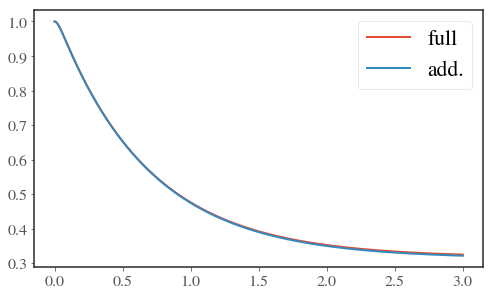

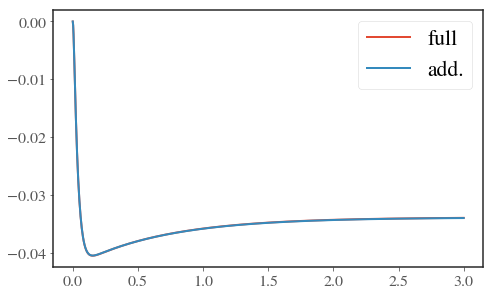

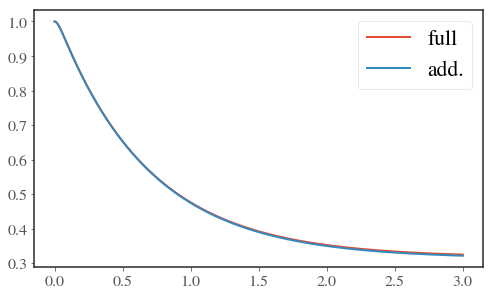

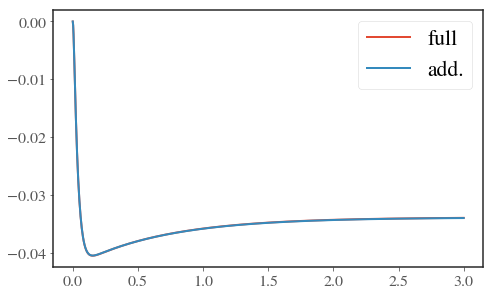

In [4]:
plt.plot(timelist, data.expect[0], label='full')
plt.plot(timelist, data_add.expect[0], label='add.')
plt.legend()
plt.figure()

plt.plot(timelist, data.expect[1].real, label='full')
plt.plot(timelist, data_add.expect[1].real, label='add.')
plt.legend()
plt.figure()
plt.show()

In [28]:
def plot_spectra(timelist, pops, taulist, g1s, specs, freqs, g2s,
                freq_window=1000., tau_window=2., dyn_window_div = 7.):
    plt.close('all')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(14,12))
    #f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    #f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,6))
    label = ['Full', 'Naive']
    ls = ['dashed', 'solid']
    for i, spec in enumerate(specs):
        g_1  = g1s[i]
        freq = freqs[i]
        ax1.plot(timelist, pops[i],
                label=label[i], linestyle=ls[i])
        ax3.plot(taulist[0:int(len(taulist)/tau_window)],
                 g_1.real[0:int(len(taulist)/tau_window)], 
                 label=label[i], linestyle=ls[i])
        #ax4.plot(taulist[0:int(len(taulist)/tau_window)],
        #         g_1.imag[0:int(len(taulist)/tau_window)], 
        #         label=label[i], linestyle=ls[i])
        ax4.plot(timelist, g2s[i], label=label[i], linestyle=ls[i])
        ax2.plot(freq, spec, label=label[i], linestyle=ls[i])
    ax1.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    ax3.set_xlim(0,taulist[int((len(taulist)-1)/dyn_window_div)])
    #ax4.set_xlim(0,taulist[int((len(taulist)-1)/dyn_window_div)])
    ax4.set_xlim(0,timelist[int((len(timelist)-1)/dyn_window_div)])
    ax1.set_xlabel(r"Time")
    ax2.set_xlabel(r"Frequency $cm^{-1}$")
    #ax2.axvline(eps, linestyle='dashed',color='k', alpha=0.4)
    if freq_window is not None:
        ax2.set_xlim(-freq_window,freq_window)

    ax1.set_ylabel(r"Excited state population")
    ax2.set_ylabel(r"Fluorescence intensity (arb. units)")
    ax3.set_ylabel(r"$Re[g^{(1)}(\tau)]$") # coherence
    #ax4.set_ylabel(r"$Im[g_1(\tau)]$") # coherence
    ax4.set_ylabel(r"$g^{(2)}_{ss}(\tau)$") # coherence
    ax3.set_xlabel(r"$\tau$")
    #ax4.set_xlabel(r"$\tau$") # if lower right is imag part of g1
    ax4.set_xlabel(r"$\tau$")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()

# First order coherence function and emission spectra

In [6]:
method = 'adams'
order = 12
reload(EM)

def RF_spectrum(H, rho_0, timelist, taulist, L, sigma_RC, 
                steps_per_tau=700.,nsteps=8000, tau_f=2., label='Full'):
    options = qt.Options(nsteps=nsteps, store_states=True)
    E_op = sigma_RC.dag()*sigma_RC
    ti = time.time()
    P = mesolve(H, rho_0, timelist, c_ops=[L], options=options).states
    pop = [((E_op*p).tr()).real for p in P]

    print "Completed initial dynamics calculations for {} in {}  seconds.".format(label, time.time()-ti)
    ti = time.time()
    Lambda_0 = sigma_RC*sum(P)
    del P
    Lambda_t = mesolve(H, Lambda_0, taulist, [L], options=options, progress_bar=None)

    g_1 = np.array([(sigma_RC.dag()*l).tr() for l in Lambda_t.states])
    g_1/=abs(g_1[0])

    spec = sp.fftpack.fft(g_1)
    dt = taulist[1]-taulist[0]
    freq = 2 * pi * np.array(sp.fftpack.fftfreq(spec.size, dt))
    spec = 2 * dt* np.real(spec)
    #freq, spec = qt.spectrum_correlation_fft(taulist, g_1) # old method
    spec-= min(spec)
    spec = spec/sum(spec)
    freq, spec = zip(*sorted(zip(freq, np.array(spec).real)))
    print "Completed correlation function calculations for {} in {} seconds.".format(label, time.time()-ti)
    return pop, g_1, spec, freq

# Second order coherence functions

In [7]:
def coherence_2nd_order_ss(H, tlist, c_ops, sigma, rho0=None):
    """
    Calculate the correlation function <sigma_dag(0)sigma_dag(tau)sigma(tau)sigma(0)>

    (ss_gtt = steadystate general two-time)
    
    See, Gardiner, Quantum Noise, Section 5.2.1

    .. note::
        Experimental. 
    """
    ti = time.time()
    if rho0 == None:
        rho0 = steadystate(H, c_ops)
    dat = mesolve(H, sigma * rho0 * sigma.dag(), tlist, c_ops, [sigma.dag() * sigma]).expect[0]
    print "G2 took {:0.3f} seconds".format(time.time()-ti)
    return dat

In [24]:

        

def RF_data(detuning=0., alpha=10, Rabi=1., w0=50., t_f=4., steps_per_tau=700.,
                steps_per_t=900, nsteps=8000, tau_f=2.):
    Gamma_EM =  1. #1*5.309e-3
    detuning = detuning*Gamma_EM #detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
    epsilon = 1000. #1*ev_to_inv_cm
    w_laser = epsilon + detuning
    Rabi = Rabi*Gamma_EM #Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    T_ph = 77.
    #w0 = 50.
    wc = 52.
    Gamma =  25. #(w0**2)/100.
    alpha_ph = alpha #alpha*ev_to_inv_cm
    
    #kappa= np.sqrt(np.pi * alpha_ph * w0 / 2.)
    #shift = ((kappa**2)/w0)
    #w_laser #+= shift
    
    
    #Rabi = Gamma_EM*Rabi #Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    J = J_multipolar
    
    kappa= np.sqrt(np.pi * alpha_ph * w0 / 2.)
    shift = ((kappa**2)/w0)
    #w_laser += shift
    H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
    print "Driven Hamiltonian: \n", H_sub.full()
    n_RC = Occupation(w0, T_ph)
    
    
    #print "T_ph={}".format(T_ph)
    #print "Exact solution took {} seconds.".format(time.time()-ti)
    
    if abs(alpha)>0:
        N = 7
        I = qeye(N)
        L_RC, H, A_EM, A_nrwa, Z, wRC, kappa, gamma = RC.RC_function_gen(H_sub, sigma, T_ph, Gamma, w0, alpha_ph, N, 
                                                                  silent=False, w_laser=w_laser)
        H_add = tensor(H_sub, I)
        E_op = tensor(E*E.dag(), I) # population operator
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        sigma_RC = tensor(sigma, I)
    else:
        L_RC, H, A_EM = 0, H_sub, sigma
        H_add = H_sub
        E_op = E*E.dag() # population operator
        rho_0 = initial_sys
        sigma_RC = sigma
    eps_rot = epsilon #+((kappa**2)/wRC)
    
    labels = ['Full', 'Naive']
    L_full = -EM.L_nonsecular(H, A_EM, eps_rot, Gamma_EM, T_EM, J, silent=False, w_laser=w_laser)
    
    L_add = -EM.L_nonsecular(H_add, A_EM, eps_rot, Gamma_EM, T_EM, J, silent=False, w_laser=w_laser)
    L_EM_list = [L_full, L_add]
    #final_t = end_T_mult/Gamma_EM
    #print "final t: ", final_t
    #timelist = np.linspace(0, final_t, int(T_increments*final_t))
    timelist = np.linspace(0, t_f, t_f*steps_per_t)
    taulist = np.linspace(0, tau_f, int(tau_f*steps_per_tau))
    pop_list = []
    g1_data = []
    spectrum_data = []
    freq_data = []
    g2_data = []
    for i, L_EM in enumerate(L_EM_list):
        L = L_RC + L_EM
        ss = steadystate(H, [L])
        print "Steadystate: \n", ss.ptrace(0).full()
        pop, g1, spec, freq = RF_spectrum(H, rho_0, timelist, taulist, L, sigma_RC,
                                      nsteps=nsteps, tau_f=tau_f, label=labels[i])
        g2 = coherence_2nd_order_ss(H, timelist, [L], sigma_RC, rho0=ss)
        pop_list.append(pop)
        g1_data.append(g1)
        spectrum_data.append(spec)
        freq_data.append(freq)
        norm_den = ((ss*sigma_RC.dag()*sigma_RC).tr()**2).real
        g2_data.append(g2/norm_den)
    print "All spectra calculated."
    return timelist, pop_list, taulist, g1_data, spectrum_data, freq_data, g2_data



In [20]:
50/1000.

0.05

# No phonons

Driven Hamiltonian: 
[[ 0.0+0.j  0.5+0.j]
 [ 0.5+0.j  0.0+0.j]]
It took  0.0127429962158  seconds to build the Non-secular RWA Liouvillian
It took  0.0130910873413  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.66650008+0.j          0.00000000+0.33300017j]
 [ 0.00000000-0.33300017j  0.33349992+0.j        ]]
Completed initial dynamics calculations for Full in 2.93225097656  seconds.
Completed correlation function calculations for Full in 3.18961119652 seconds.
G2 took 0.155 seconds
All spectra calculated.


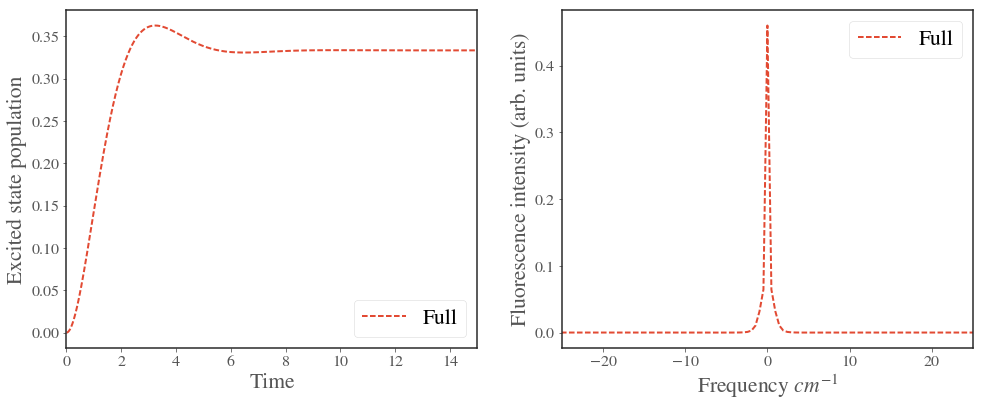

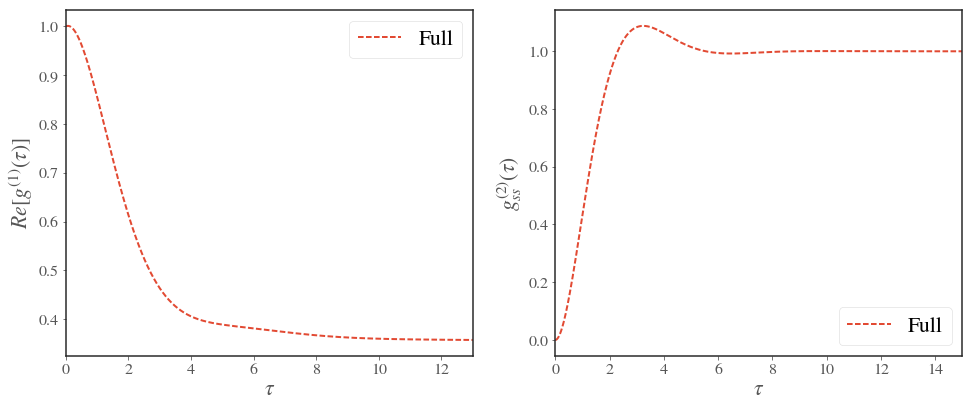

Driven Hamiltonian: 
[[ 0.+0.j  5.+0.j]
 [ 5.+0.j  0.+0.j]]
It took  0.0107789039612  seconds to build the Non-secular RWA Liouvillian
It took  0.0112590789795  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.5024508+0.j          0.0000000+0.04901603j]
 [ 0.0000000-0.04901603j  0.4975492+0.j        ]]
Completed initial dynamics calculations for Full in 2.32430005074  seconds.
Completed correlation function calculations for Full in 2.66324710846 seconds.
G2 took 0.159 seconds
All spectra calculated.


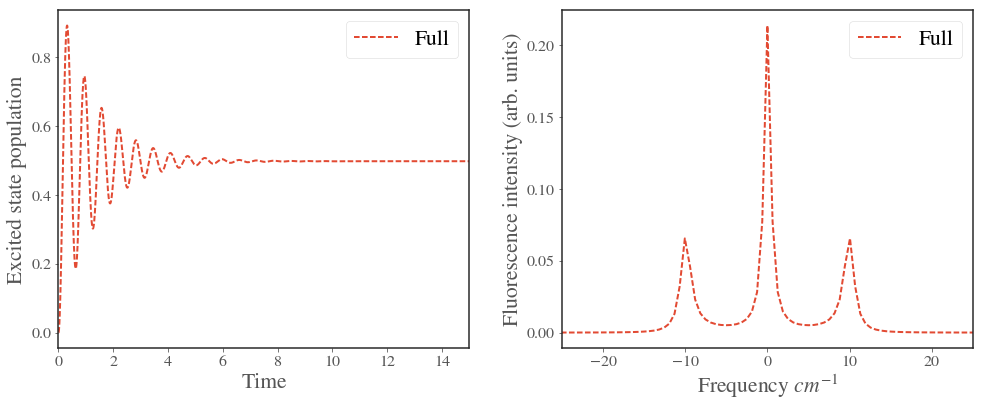

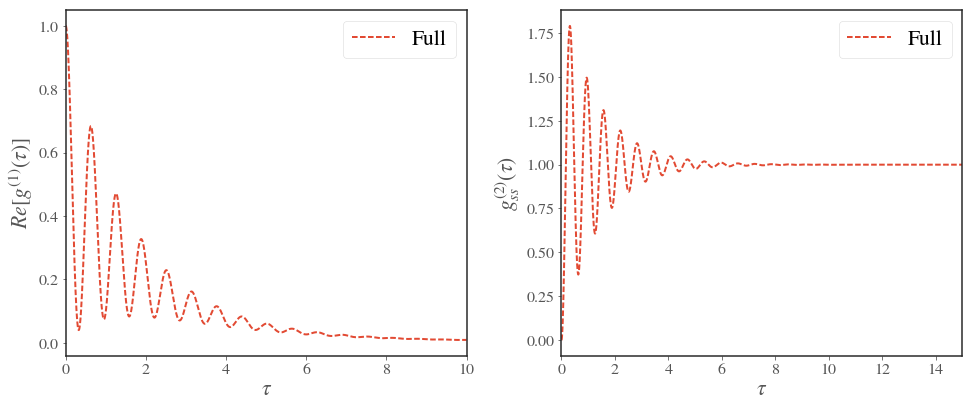

Driven Hamiltonian: 
[[  0.0+0.j   0.5+0.j]
 [  0.5+0.j -10.0+0.j]]
It took  0.0104730129242  seconds to build the Non-secular RWA Liouvillian
It took  0.0110130310059  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.99751861+0.j         0.04962403+0.0025562j]
 [ 0.04962403-0.0025562j  0.00248139+0.j       ]]
Completed initial dynamics calculations for Full in 2.34734487534  seconds.
Completed correlation function calculations for Full in 2.79964804649 seconds.
G2 took 0.155 seconds
All spectra calculated.


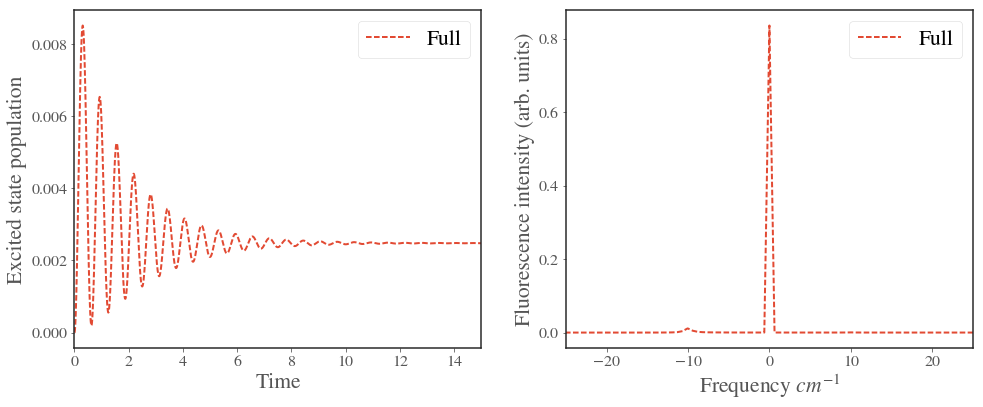

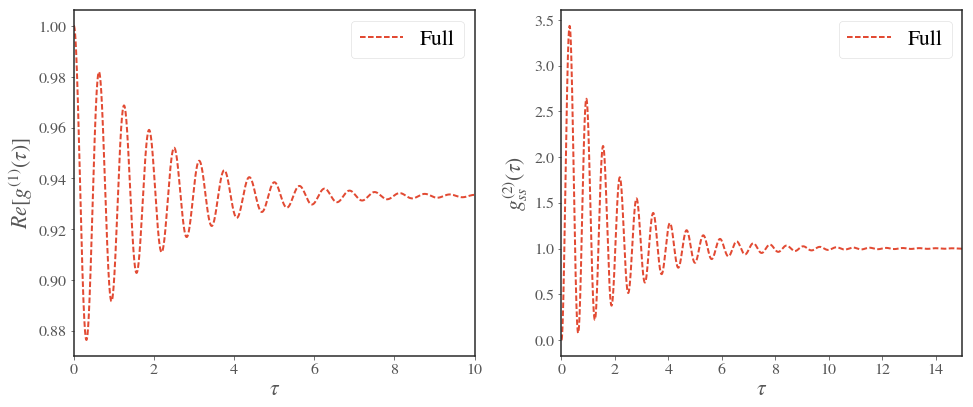

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -10.+0.j]]
It took  0.0110220909119  seconds to build the Non-secular RWA Liouvillian
It took  0.0119340419769  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.83361246+0.j          0.33275659+0.01696539j]
 [ 0.33275659-0.01696539j  0.16638754+0.j        ]]
Completed initial dynamics calculations for Full in 2.56614208221  seconds.
Completed correlation function calculations for Full in 2.96129202843 seconds.
G2 took 0.164 seconds
All spectra calculated.


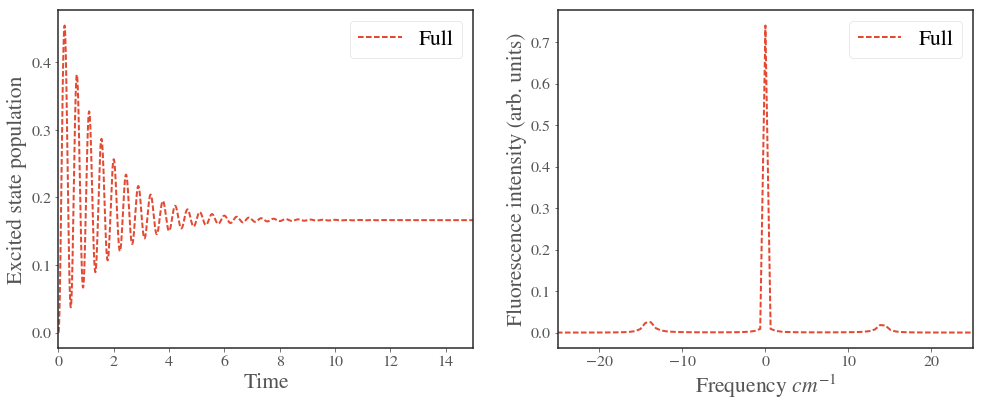

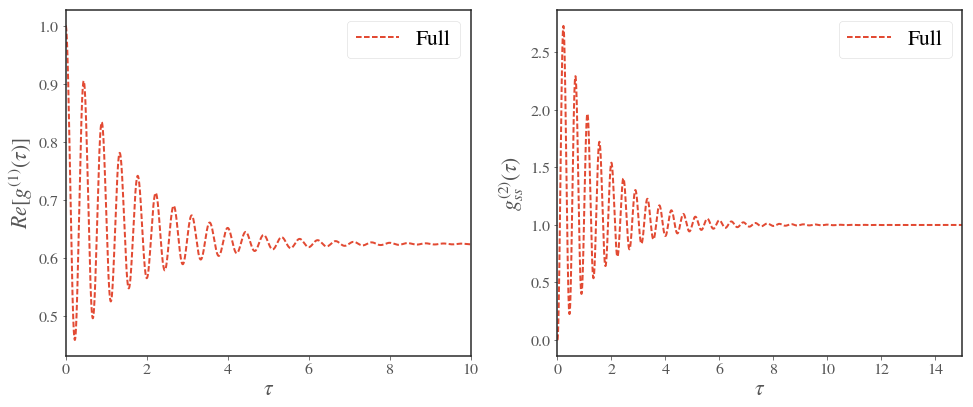

In [91]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=0, Rabi=1.,
                                                                             t_f=15, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=13.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=0, Rabi=10., 
                                                                             t_f=15, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=10.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=10., alpha=0, Rabi=1.,
                                                                             t_f=15, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=10.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=10., alpha=0, Rabi=10.,
                                                                             t_f=15, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=10.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=25., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[ 0.0+0.j  0.5+0.j]
 [ 0.5+0.j  0.0+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.28075003624  seconds to build the Non-secular RWA Liouvillian
It took  0.324460983276  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.97798391+0.j         -0.00406270+0.02036172j]
 [-0.00406270-0.02036172j  0.02201609+0.j        ]]
Completed initial dynamics calculations for Full in 3.29397201538  seconds.
Completed correlation function calculations for Full in 2.37729597092 seconds.
G2 took 0.613 seconds
All spectra calculated.


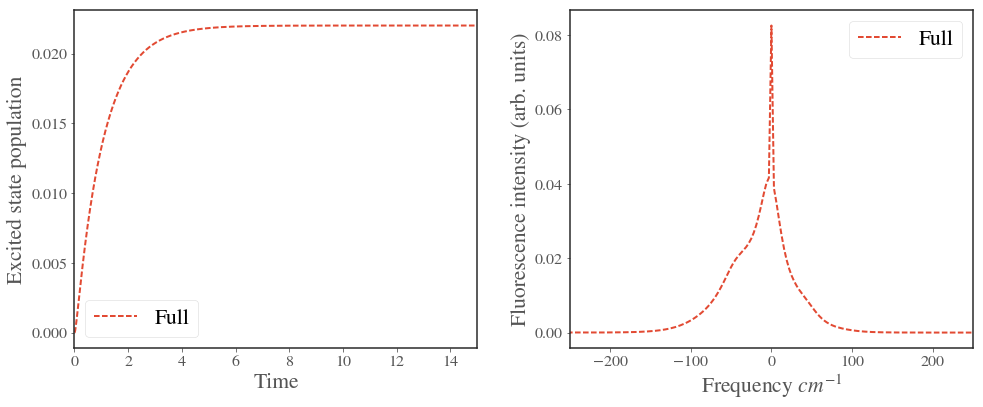

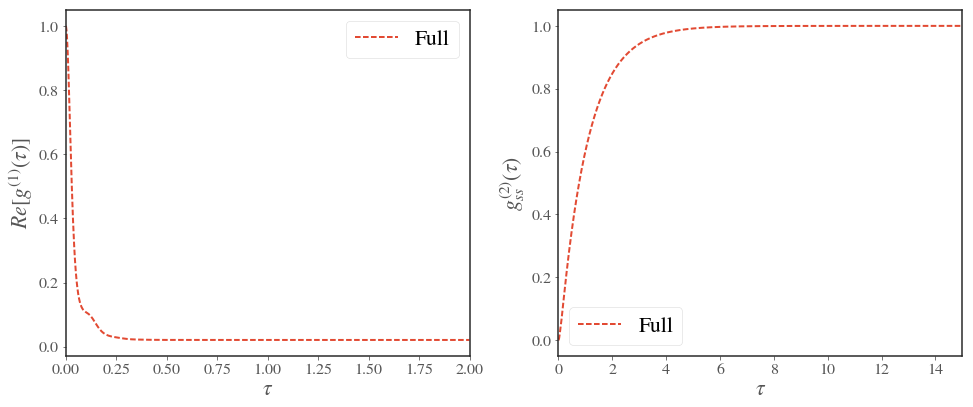

Driven Hamiltonian: 
[[ 0.0+0.j  0.5+0.j]
 [ 0.5+0.j  0.0+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.289924860001  seconds to build the Non-secular RWA Liouvillian
It took  0.150847911835  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.99548189+0.j         -0.00402731+0.00352678j]
 [-0.00402731-0.00352678j  0.00451811+0.j        ]]
Completed initial dynamics calculations for Full in 3.56246685982  seconds.
Completed correlation function calculations for Full in 2.23860406876 seconds.
G2 took 0.560 seconds
All spectra calculated.


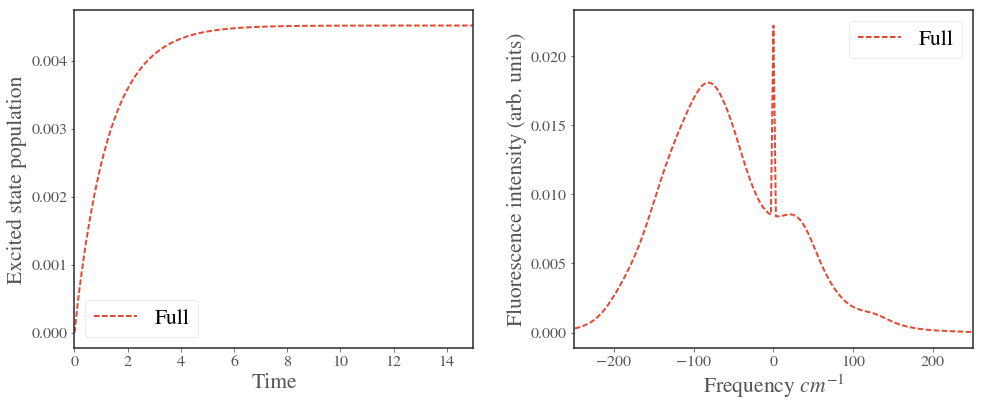

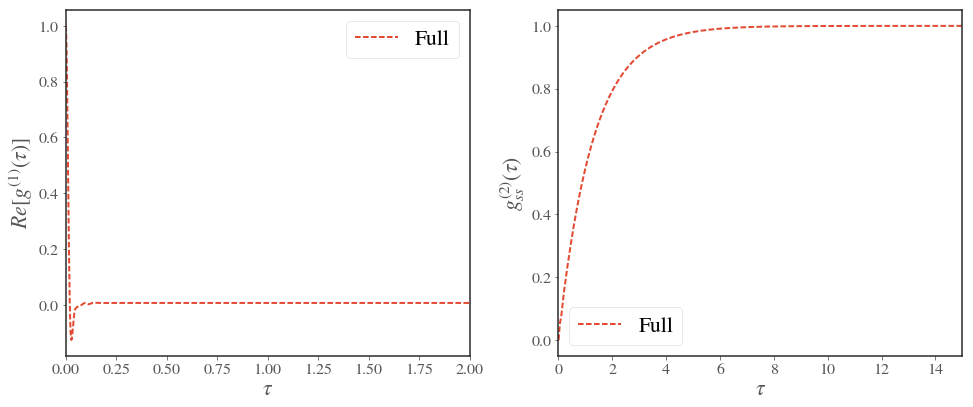

Driven Hamiltonian: 
[[ 0.0+0.j  0.5+0.j]
 [ 0.5+0.j  0.0+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.278908014297  seconds to build the Non-secular RWA Liouvillian
It took  0.332590103149  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.98362451+0.j         -0.00511207+0.01513313j]
 [-0.00511207-0.01513313j  0.01637549+0.j        ]]
Completed initial dynamics calculations for Full in 4.77115106583  seconds.
Completed correlation function calculations for Full in 3.03741908073 seconds.
G2 took 0.991 seconds
All spectra calculated.


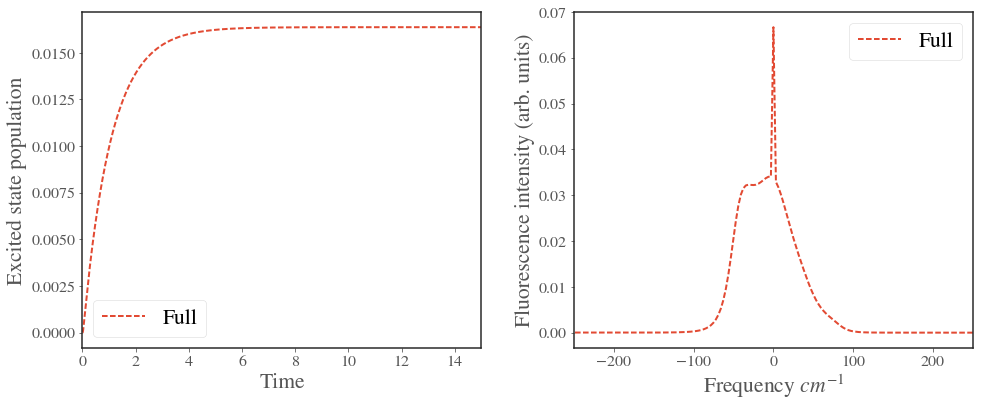

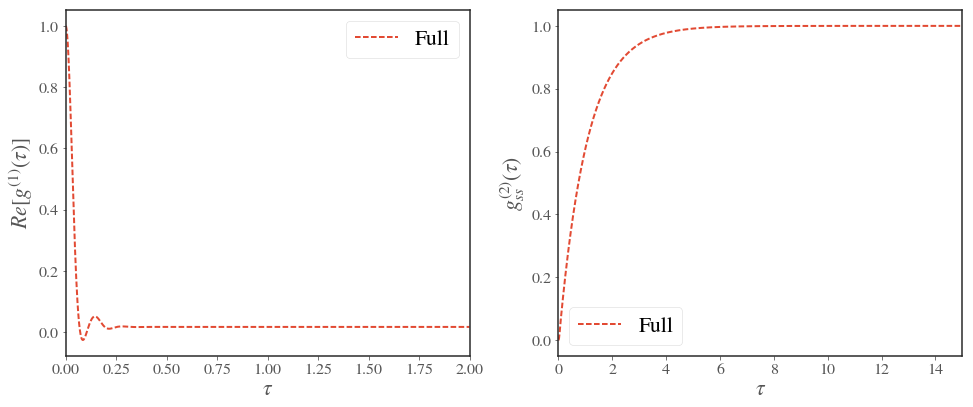

Driven Hamiltonian: 
[[ 0.0+0.j  0.5+0.j]
 [ 0.5+0.j  0.0+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.316967964172  seconds to build the Non-secular RWA Liouvillian
It took  0.146749973297  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.99623835+0.j         -0.00446440+0.00320691j]
 [-0.00446440-0.00320691j  0.00376165+0.j        ]]
Completed initial dynamics calculations for Full in 3.53480815887  seconds.
Completed correlation function calculations for Full in 2.26552414894 seconds.
G2 took 1.076 seconds
All spectra calculated.


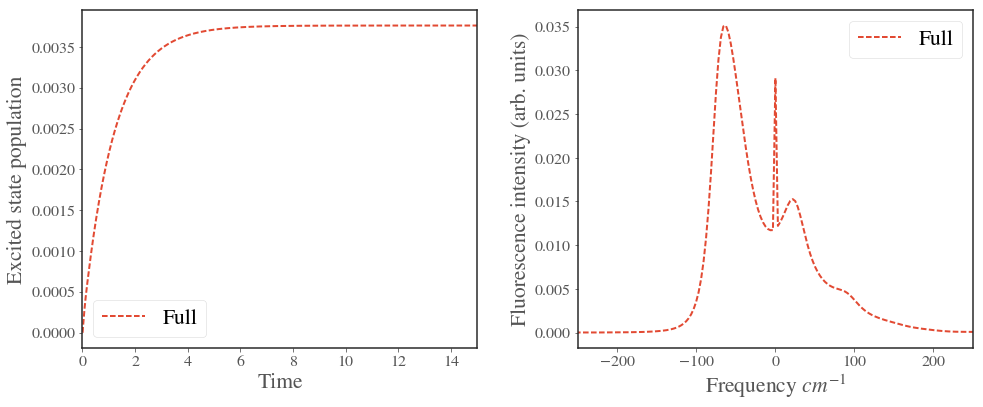

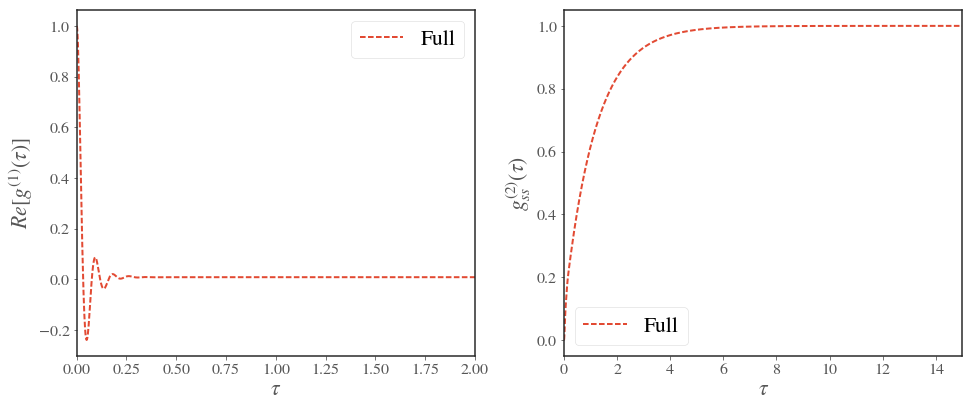

In [82]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=10, Rabi=1., w0=50.,
                                                                             t_f=15, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=60, Rabi=1., w0=50.,
                                                                             t_f=15, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=10, Rabi=1., w0=25.,
                                                                             t_f=15, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=60, Rabi=1., w0=25.,
                                                                             t_f=15, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=2.)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

# Mollow regime

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.297214984894  seconds to build the Non-secular RWA Liouvillian
It took  0.110357999802  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.52933857+0.j         -0.08660900+0.02135692j]
 [-0.08660900-0.02135692j  0.47066143+0.j        ]]
Completed initial dynamics calculations for Full in 1.04757094383  seconds.
Completed correlation function calculations for Full in 1.40378785133 seconds.
G2 took 0.345 seconds
All spectra calculated.


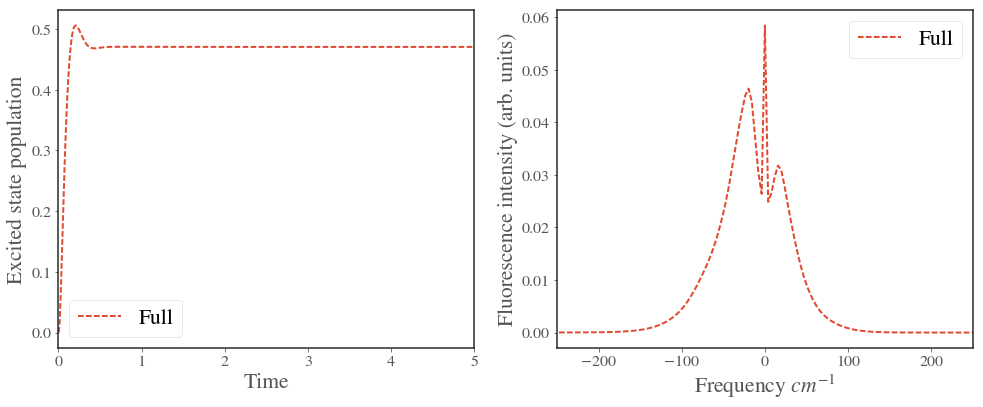

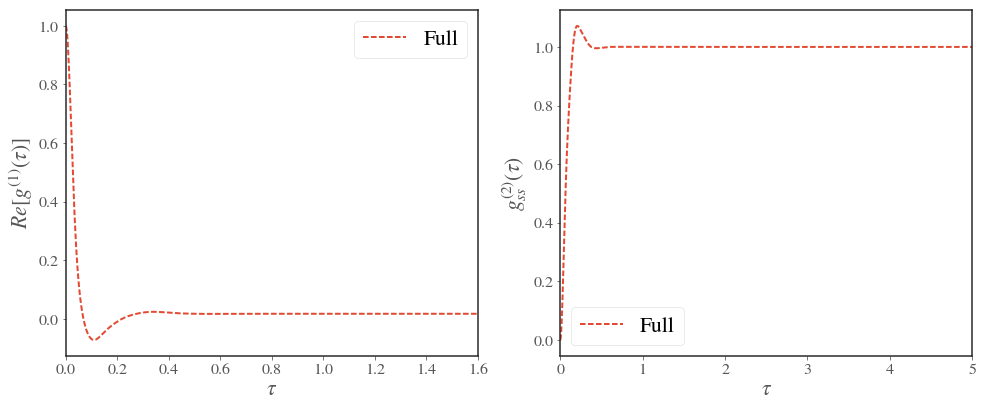

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.275485038757  seconds to build the Non-secular RWA Liouvillian
It took  0.108073949814  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.63472803+0.j         -0.07346119+0.01420677j]
 [-0.07346119-0.01420677j  0.36527197+0.j        ]]
Completed initial dynamics calculations for Full in 1.28875184059  seconds.
Completed correlation function calculations for Full in 0.905956983566 seconds.
G2 took 0.184 seconds
All spectra calculated.


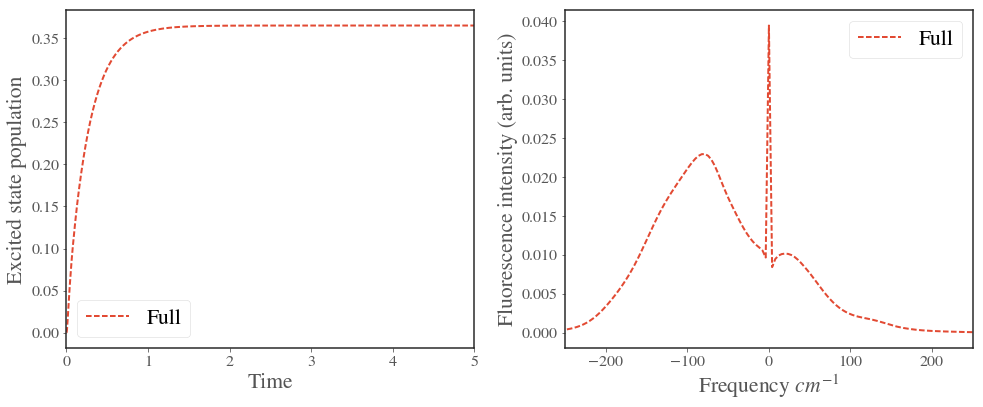

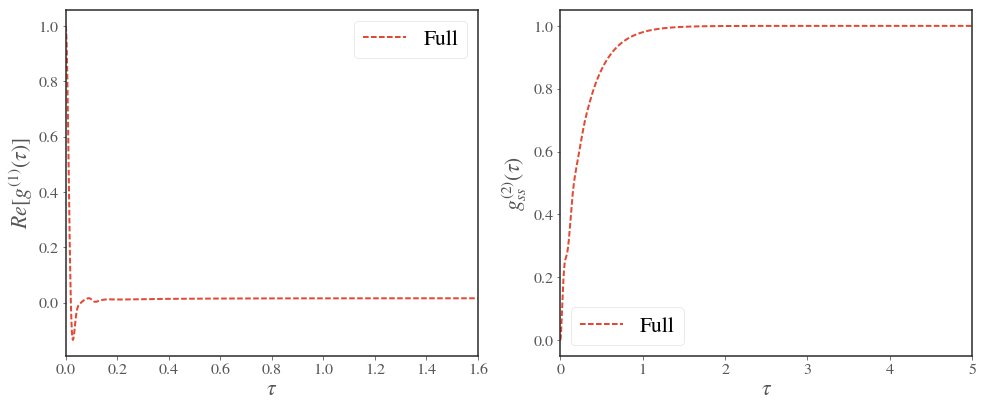

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.243406057358  seconds to build the Non-secular RWA Liouvillian
It took  0.112782001495  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.55218586+0.j         -0.08371705+0.02042897j]
 [-0.08371705-0.02042897j  0.44781414+0.j        ]]
Completed initial dynamics calculations for Full in 1.07741498947  seconds.
Completed correlation function calculations for Full in 0.840218067169 seconds.
G2 took 0.345 seconds
All spectra calculated.


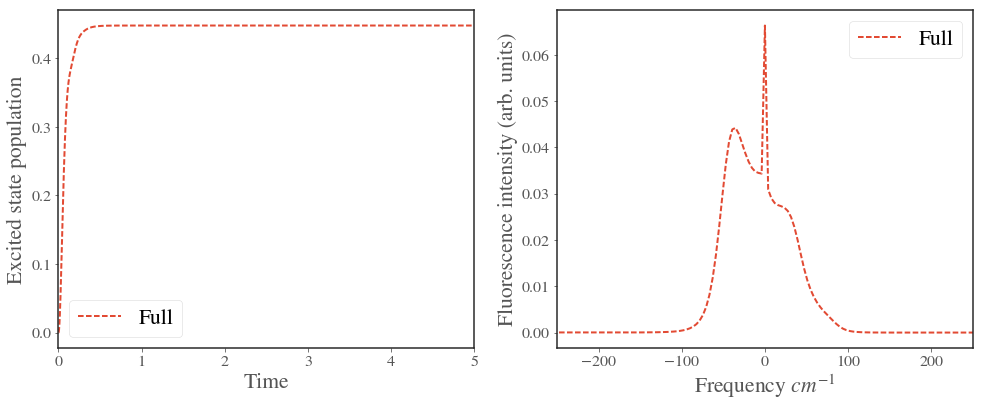

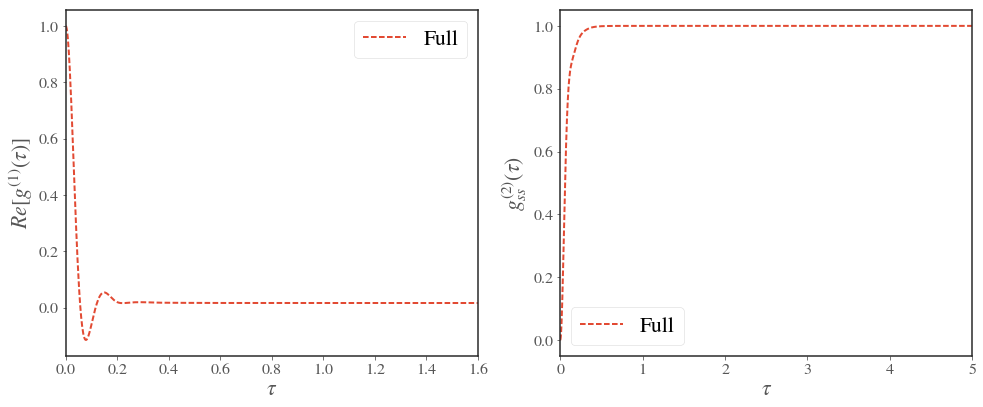

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j   0.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.394037008286  seconds to build the Non-secular RWA Liouvillian
It took  0.136216878891  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.70664933+0.j         -0.07569085+0.01246527j]
 [-0.07569085-0.01246527j  0.29335067+0.j        ]]
Completed initial dynamics calculations for Full in 1.21641302109  seconds.
Completed correlation function calculations for Full in 0.901777029037 seconds.
G2 took 0.351 seconds
All spectra calculated.


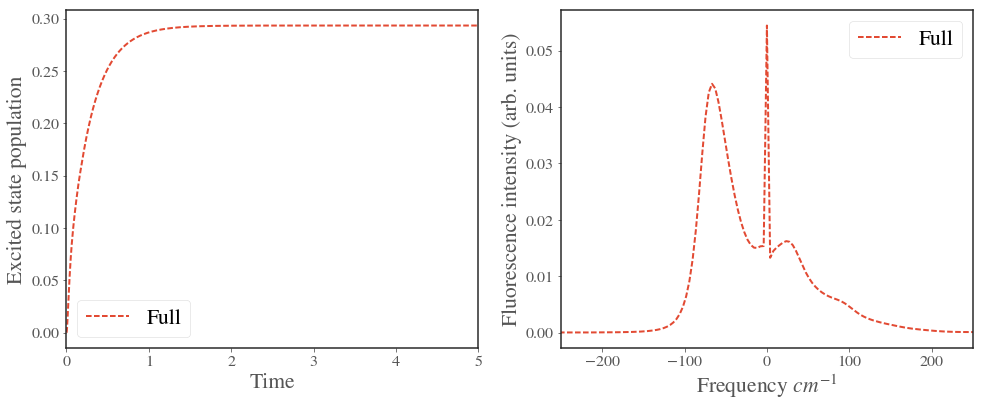

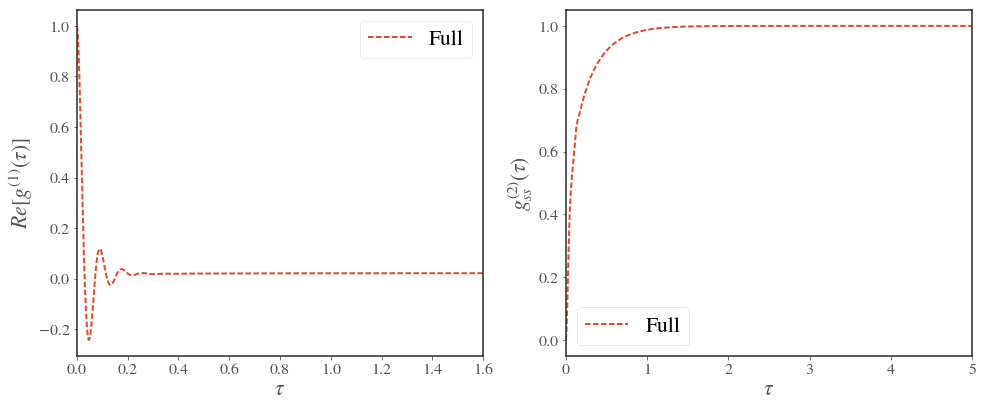

In [86]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=10, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=60, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=10, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)


timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=0., alpha=60, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=250., tau_window=1., dyn_window_div=1.)

## Mollow and detuning $\Delta \approx \alpha$

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.256452083588  seconds to build the Non-secular RWA Liouvillian
It took  0.106600046158  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.40143675+0.j         -0.04040244+0.02860469j]
 [-0.04040244-0.02860469j  0.59856325+0.j        ]]
Completed initial dynamics calculations for Full in 0.999963998795  seconds.
Completed correlation function calculations for Full in 0.936197042465 seconds.
G2 took 0.225 seconds
All spectra calculated.


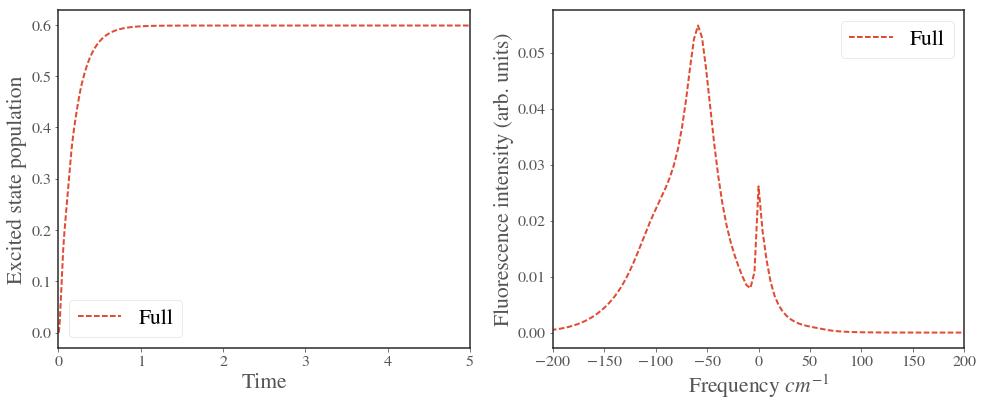

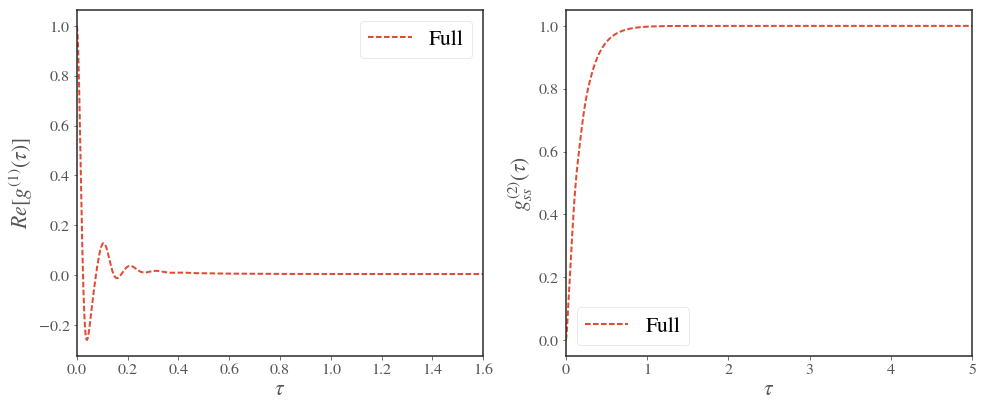

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.430556058884  seconds to build the Non-secular RWA Liouvillian
It took  0.195210933685  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.44763848+0.j        -0.06049992+0.0226746j]
 [-0.06049992-0.0226746j  0.55236152+0.j       ]]
Completed initial dynamics calculations for Full in 1.47141098976  seconds.
Completed correlation function calculations for Full in 0.998790979385 seconds.
G2 took 0.320 seconds
All spectra calculated.


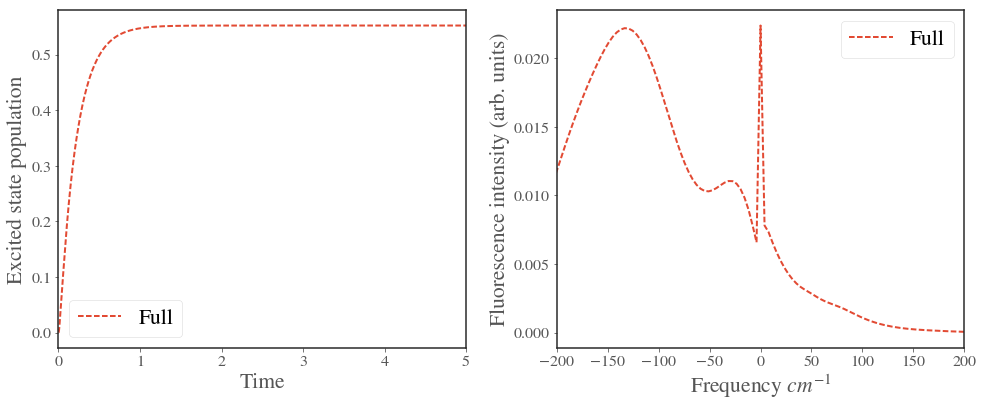

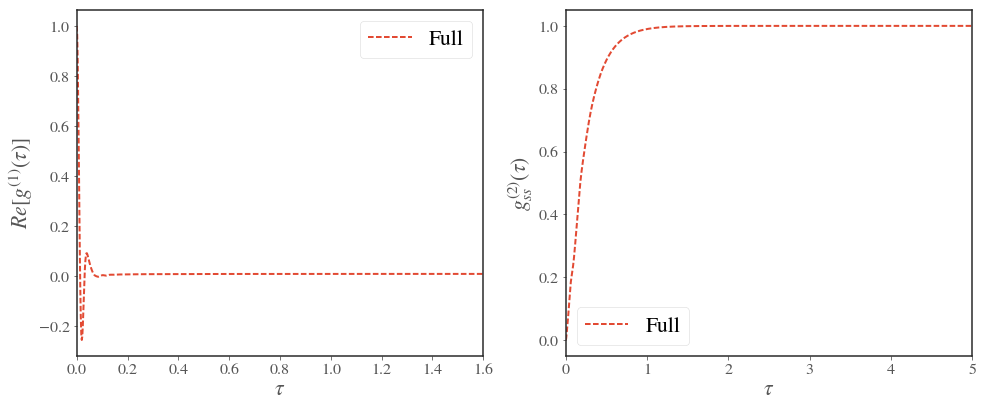

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.235013008118  seconds to build the Non-secular RWA Liouvillian
It took  0.105239152908  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.45408069+0.j         -0.02021569+0.02678793j]
 [-0.02021569-0.02678793j  0.54591931+0.j        ]]
Completed initial dynamics calculations for Full in 1.3853700161  seconds.
Completed correlation function calculations for Full in 0.984528064728 seconds.
G2 took 0.331 seconds
All spectra calculated.


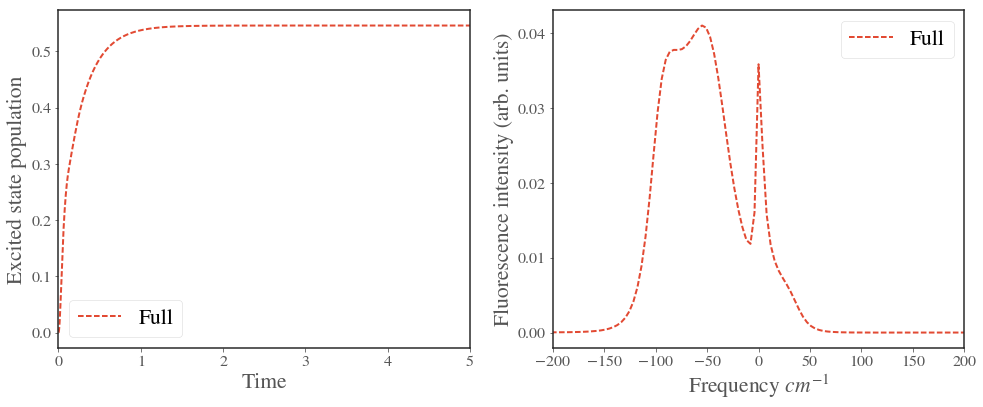

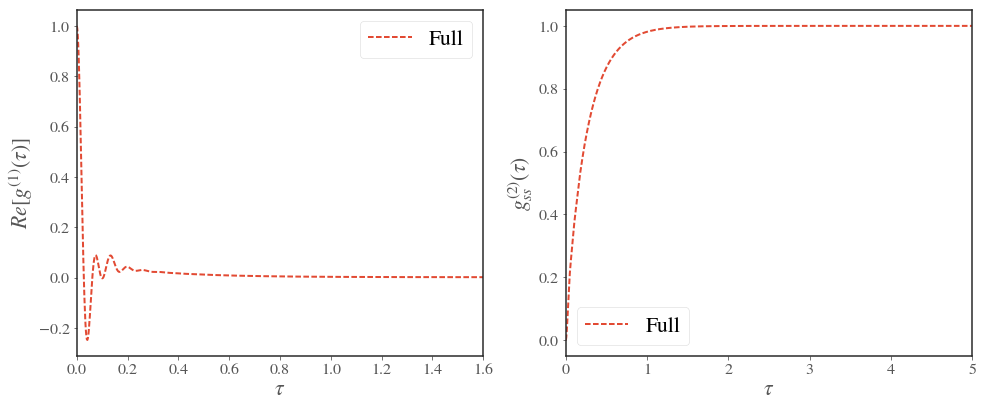

Driven Hamiltonian: 
[[  0.+0.j  10.+0.j]
 [ 10.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.251060009003  seconds to build the Non-secular RWA Liouvillian
It took  0.111477136612  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.54646886+0.j         -0.06106285+0.02091363j]
 [-0.06106285-0.02091363j  0.45353114+0.j        ]]
Completed initial dynamics calculations for Full in 1.19408082962  seconds.
Completed correlation function calculations for Full in 0.923207998276 seconds.
G2 took 0.385 seconds
All spectra calculated.


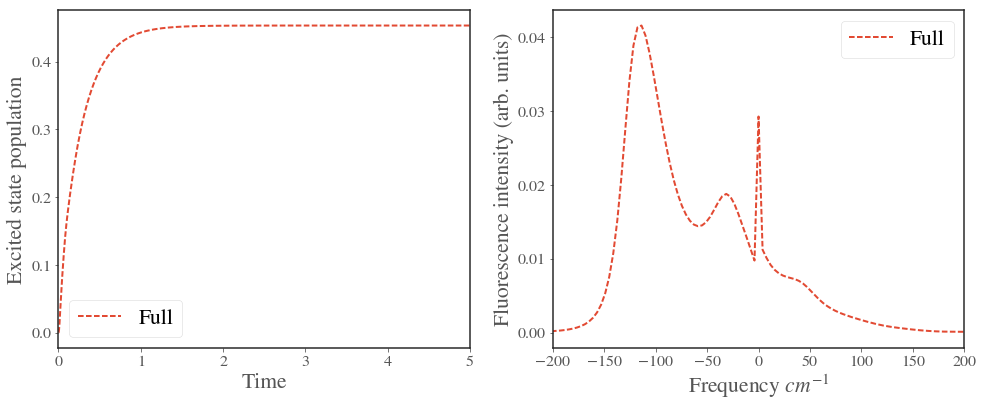

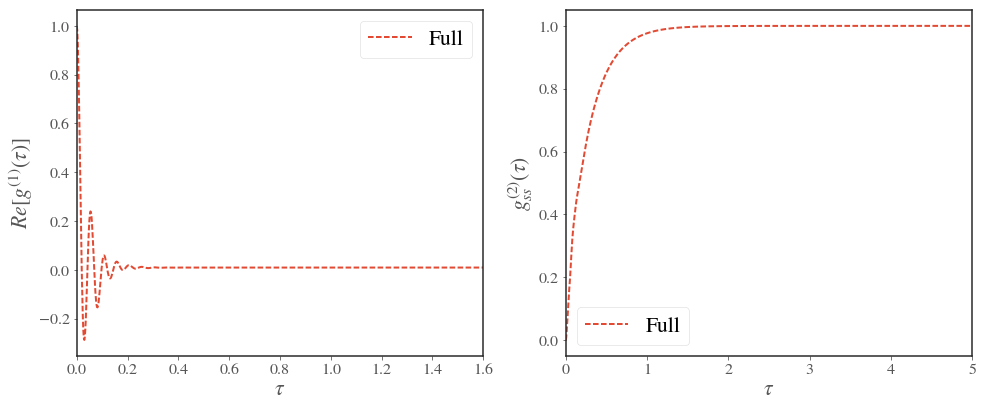

In [87]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=20., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=20., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.286993026733  seconds to build the Non-secular RWA Liouvillian
It took  0.122004985809  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.82304565+0.j          0.02605197+0.03397906j]
 [ 0.02605197-0.03397906j  0.17695435+0.j        ]]
Completed initial dynamics calculations for Full in 1.04502606392  seconds.
Completed correlation function calculations for Full in 1.02417778969 seconds.
G2 took 0.215 seconds
All spectra calculated.


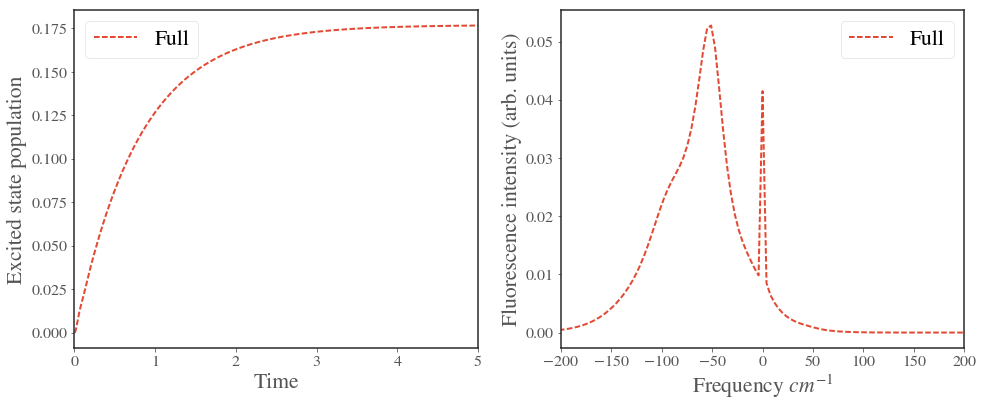

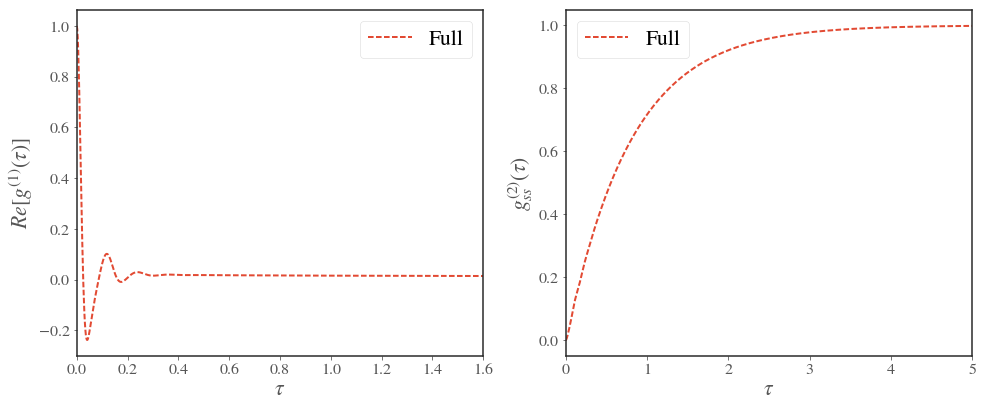

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=68.65 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.434901952744  seconds to build the Non-secular RWA Liouvillian
It took  0.216999053955  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.84270170+0.j         -0.00874687+0.02587545j]
 [-0.00874687-0.02587545j  0.15729830+0.j        ]]
Completed initial dynamics calculations for Full in 1.15030813217  seconds.
Completed correlation function calculations for Full in 1.27779388428 seconds.
G2 took 0.249 seconds
All spectra calculated.


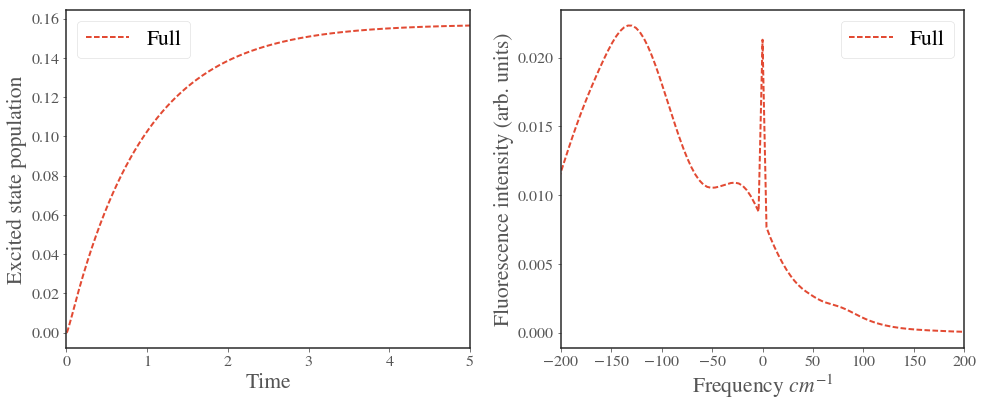

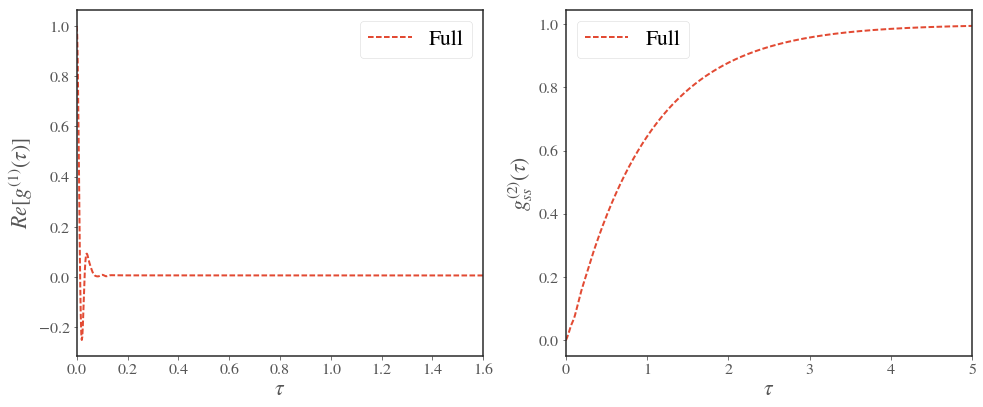

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=6 |
It took  0.248783111572  seconds to build the Non-secular RWA Liouvillian
It took  0.112131118774  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.81409066+0.j          0.02750335+0.03662224j]
 [ 0.02750335-0.03662224j  0.18590934+0.j        ]]
Completed initial dynamics calculations for Full in 1.26788902283  seconds.
Completed correlation function calculations for Full in 1.05401015282 seconds.
G2 took 0.417 seconds
All spectra calculated.


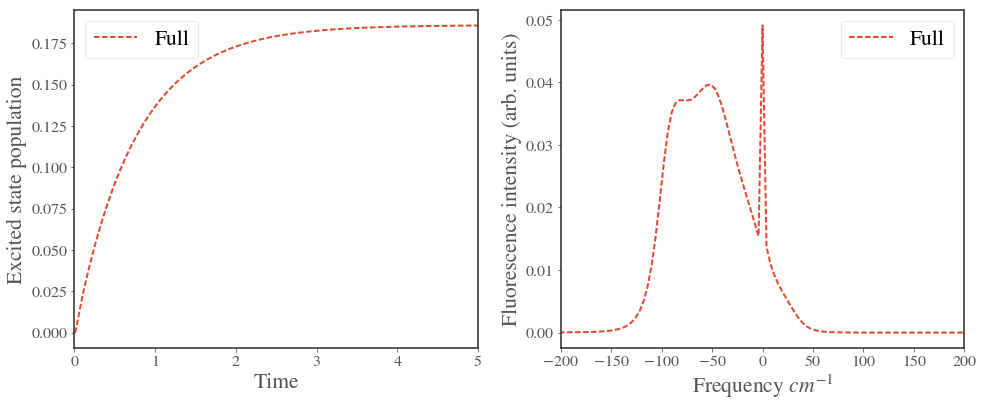

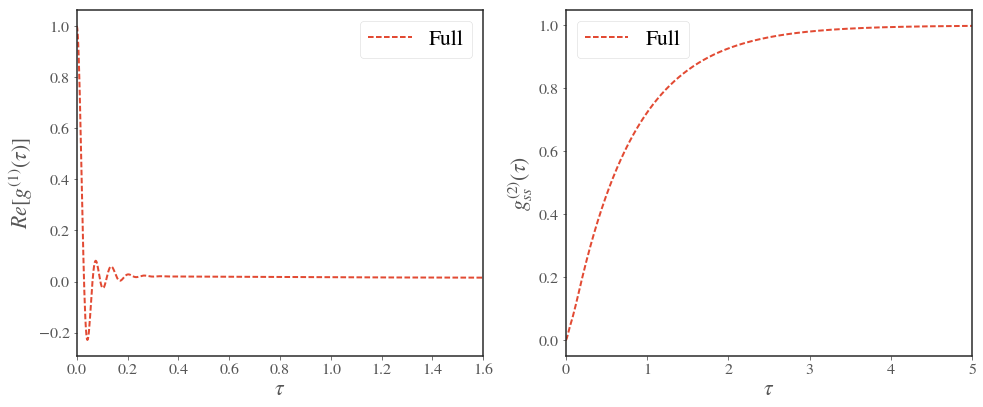

Driven Hamiltonian: 
[[  0.0+0.j   2.5+0.j]
 [  2.5+0.j -50.0+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=48.54 | Gamma_RC=25.00 | alpha_ph=60.00 | N=6 |
It took  0.268938064575  seconds to build the Non-secular RWA Liouvillian
It took  0.110217809677  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.88266501+0.j         -0.00850074+0.02173076j]
 [-0.00850074-0.02173076j  0.11733499+0.j        ]]
Completed initial dynamics calculations for Full in 1.26002717018  seconds.
Completed correlation function calculations for Full in 1.53465509415 seconds.
G2 took 0.363 seconds
All spectra calculated.


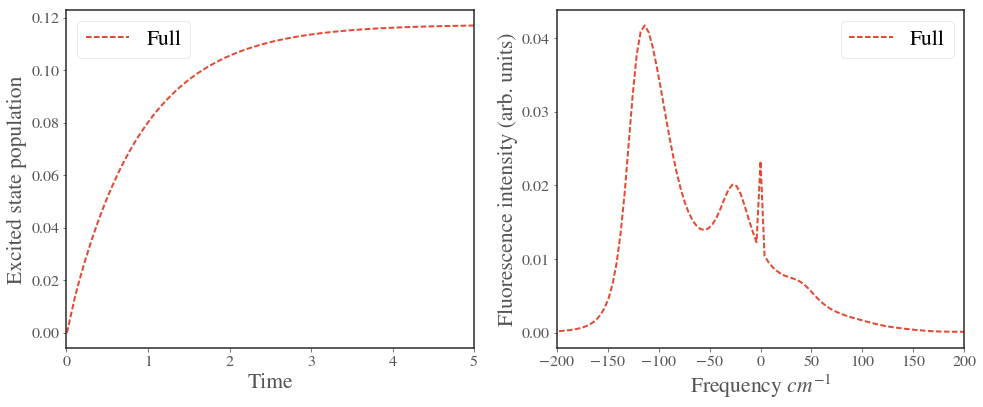

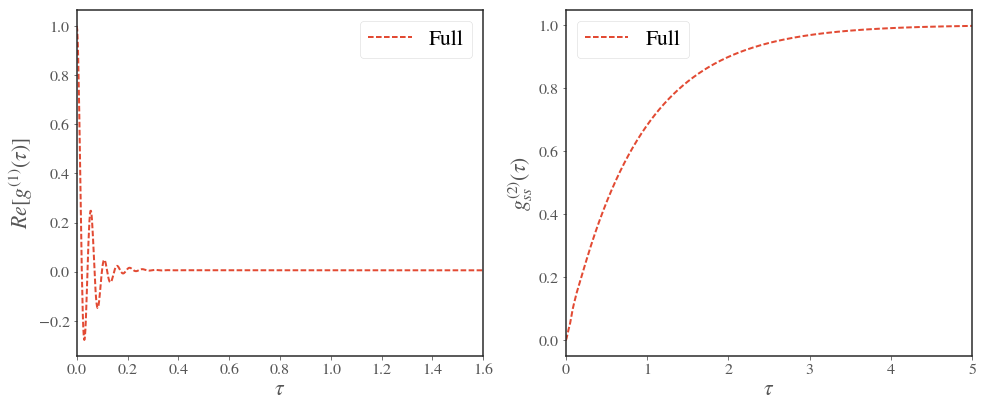

In [11]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=5., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=5., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=5., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=60, Rabi=5., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=39.63 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.367541790009  seconds to build the Non-secular RWA Liouvillian
It took  0.157804012299  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.57466709+0.j         -0.00737967+0.03893123j]
 [-0.00737967-0.03893123j  0.42533291+0.j        ]]
Completed initial dynamics calculations for Full in 1.07669496536  seconds.
Completed correlation function calculations for Full in 0.993422031403 seconds.
G2 took 0.261 seconds
All spectra calculated.


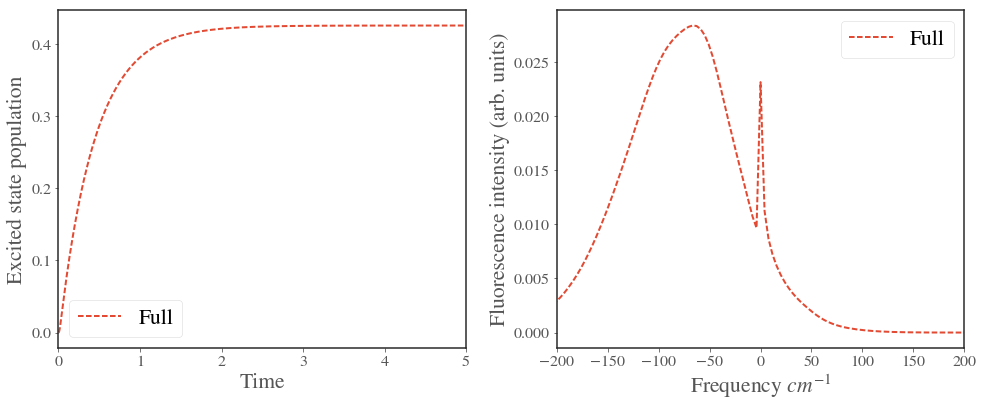

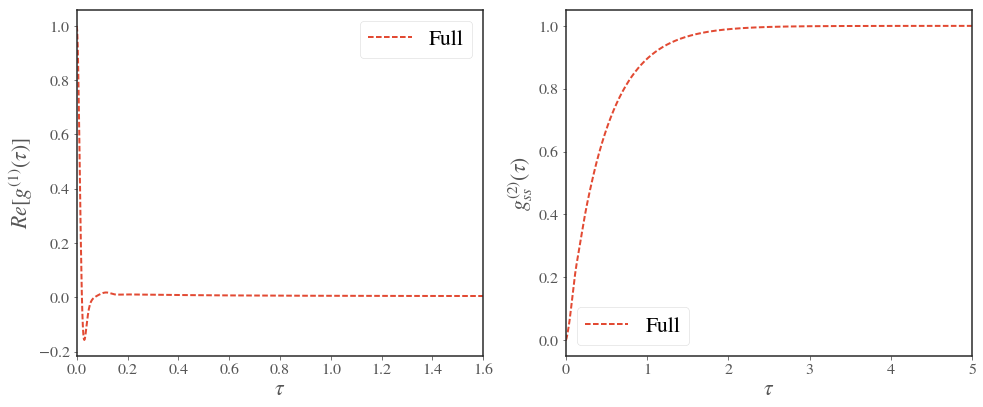

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -25.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=39.63 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.760421037674  seconds to build the Non-secular RWA Liouvillian
It took  0.163596868515  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.58746992+0.j        -0.02731942+0.0368351j]
 [-0.02731942-0.0368351j  0.41253008+0.j       ]]
Completed initial dynamics calculations for Full in 1.4600110054  seconds.
Completed correlation function calculations for Full in 0.97552895546 seconds.
G2 took 0.306 seconds
All spectra calculated.


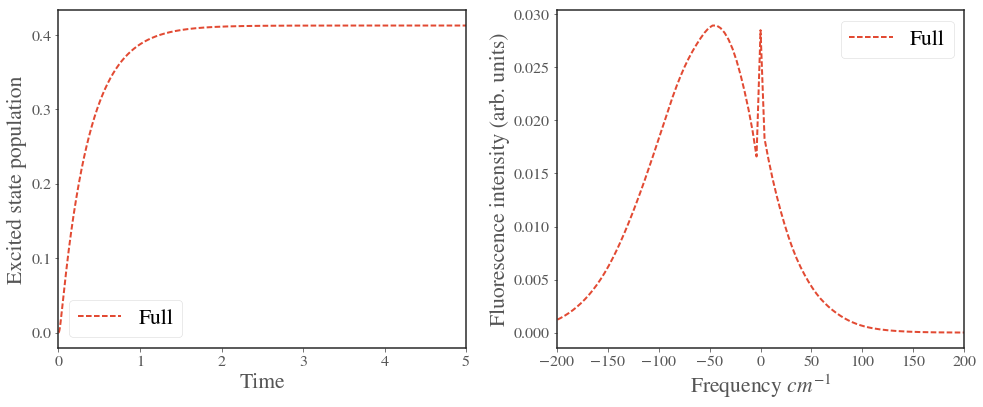

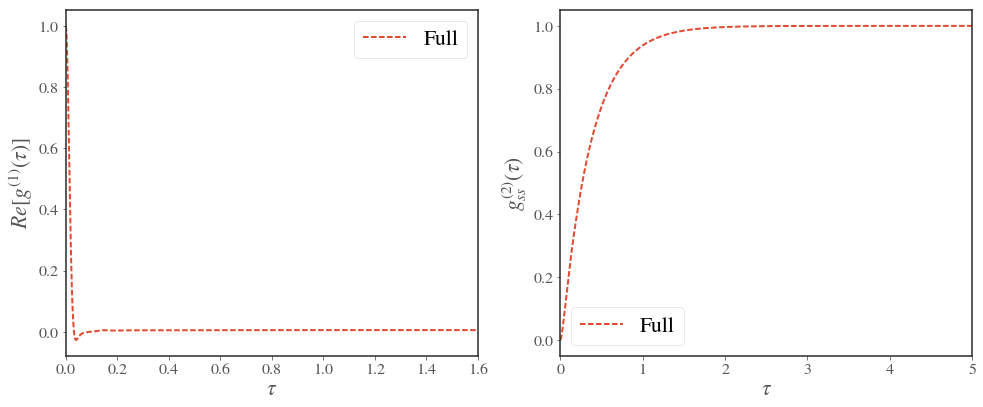

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.316792011261  seconds to build the Non-secular RWA Liouvillian
It took  0.1518471241  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.58594808+0.j         -0.01026351+0.03925943j]
 [-0.01026351-0.03925943j  0.41405192+0.j        ]]
Completed initial dynamics calculations for Full in 1.84336709976  seconds.
Completed correlation function calculations for Full in 0.991064071655 seconds.
G2 took 0.585 seconds
All spectra calculated.


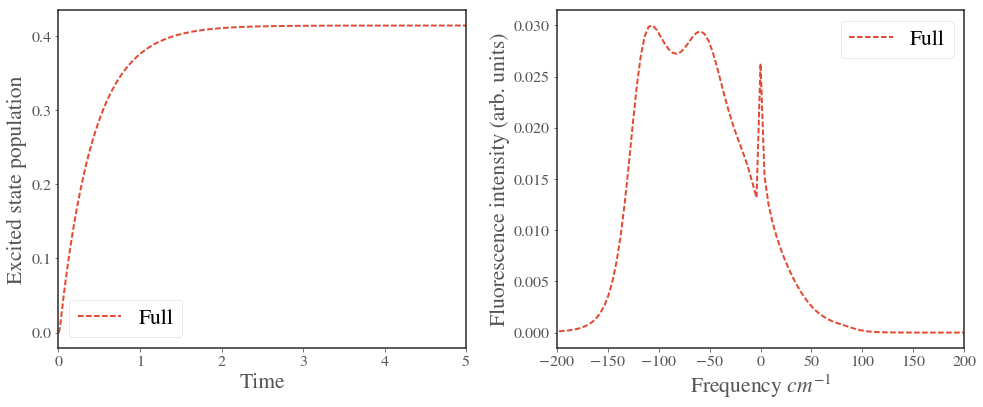

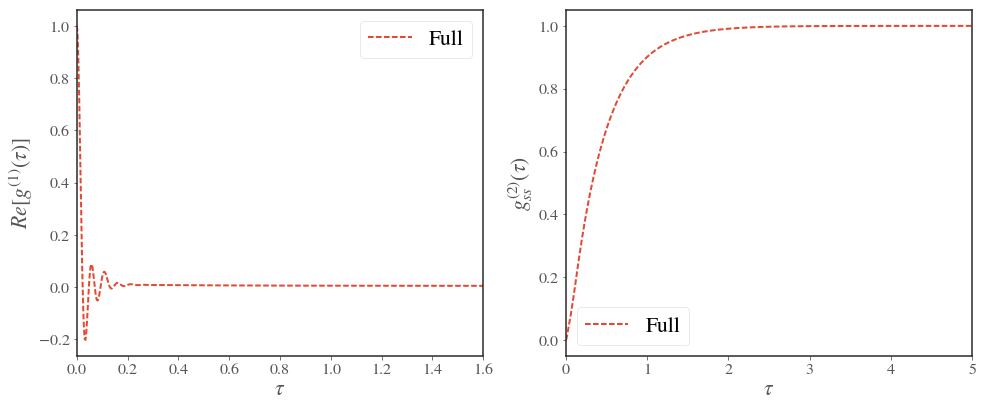

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -25.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=20.00 | N=7 |
It took  0.392028093338  seconds to build the Non-secular RWA Liouvillian
It took  0.159779071808  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.61467314+0.j         -0.02868934+0.03563651j]
 [-0.02868934-0.03563651j  0.38532686+0.j        ]]
Completed initial dynamics calculations for Full in 1.97718501091  seconds.
Completed correlation function calculations for Full in 1.45442509651 seconds.
G2 took 0.639 seconds
All spectra calculated.


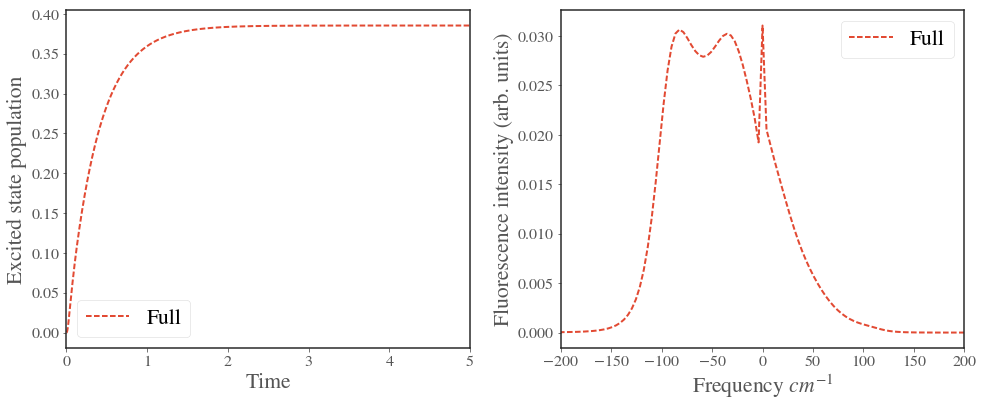

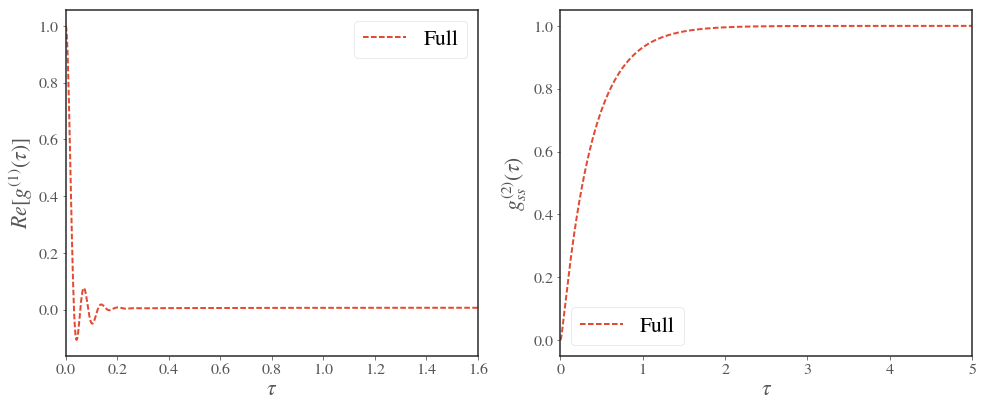

In [17]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=20, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=25, alpha=20, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=20, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=25, alpha=20, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=200., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=88.62 | Gamma_RC=25.00 | alpha_ph=100.00 | N=7 |
It took  0.342031002045  seconds to build the Non-secular RWA Liouvillian
It took  0.14689707756  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.69953268+0.j         -0.02400550+0.02219957j]
 [-0.02400550-0.02219957j  0.30046732+0.j        ]]
Completed initial dynamics calculations for Full in 1.3548989296  seconds.
Completed correlation function calculations for Full in 1.02855300903 seconds.
G2 took 0.435 seconds
Steadystate: 
[[ 0.74837658+0.j         -0.02308875+0.02512973j]
 [-0.02308875-0.02512973j  0.25162342+0.j        ]]
Completed initial dynamics calculations for Naive in 1.24825501442  seconds.
Completed correlation function calculations for Naive in 0.997797966003 seconds.
G2 took 0.402 seconds
All spectra calculated.


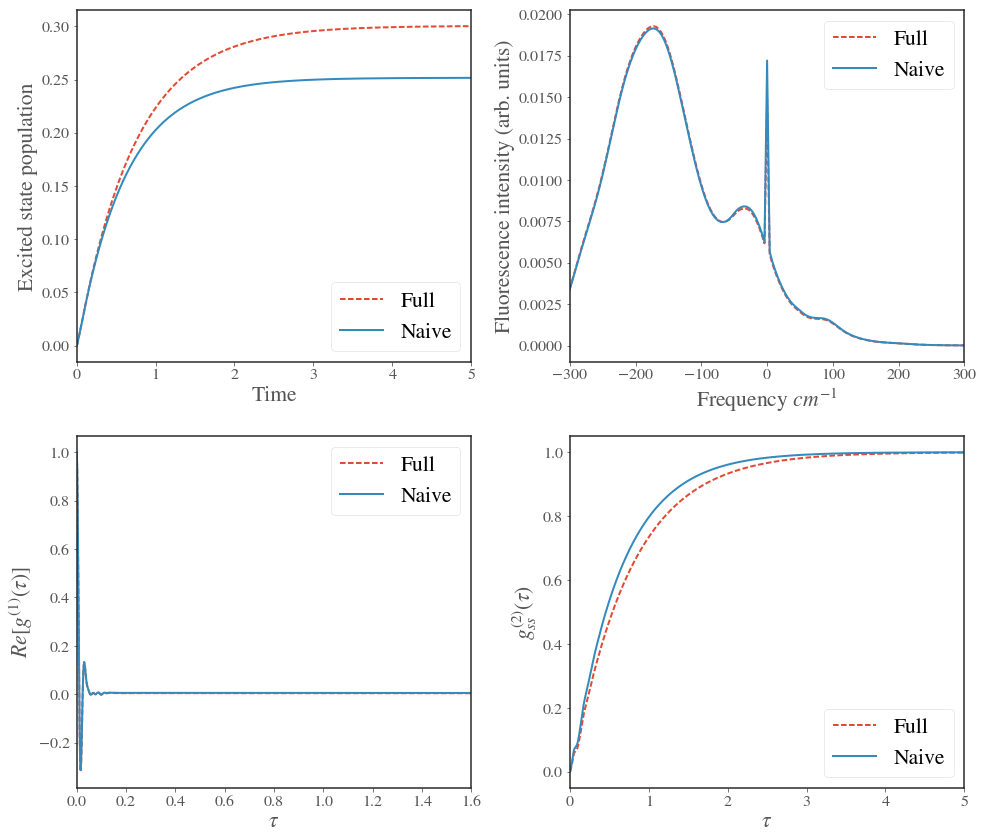

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=62.67 | Gamma_RC=25.00 | alpha_ph=50.00 | N=7 |
It took  0.357110023499  seconds to build the Non-secular RWA Liouvillian
It took  0.258063077927  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.63044496+0.j         -0.02205323+0.03039839j]
 [-0.02205323-0.03039839j  0.36955504+0.j        ]]
Completed initial dynamics calculations for Full in 1.3102889061  seconds.
Completed correlation function calculations for Full in 0.990728139877 seconds.
G2 took 0.507 seconds
Steadystate: 
[[ 0.66506664+0.j         -0.02074700+0.03346534j]
 [-0.02074700-0.03346534j  0.33493336+0.j        ]]
Completed initial dynamics calculations for Naive in 1.4328379631  seconds.
Completed correlation function calculations for Naive in 1.36368703842 seconds.
G2 took 0.634 seconds
All spectra calculated.


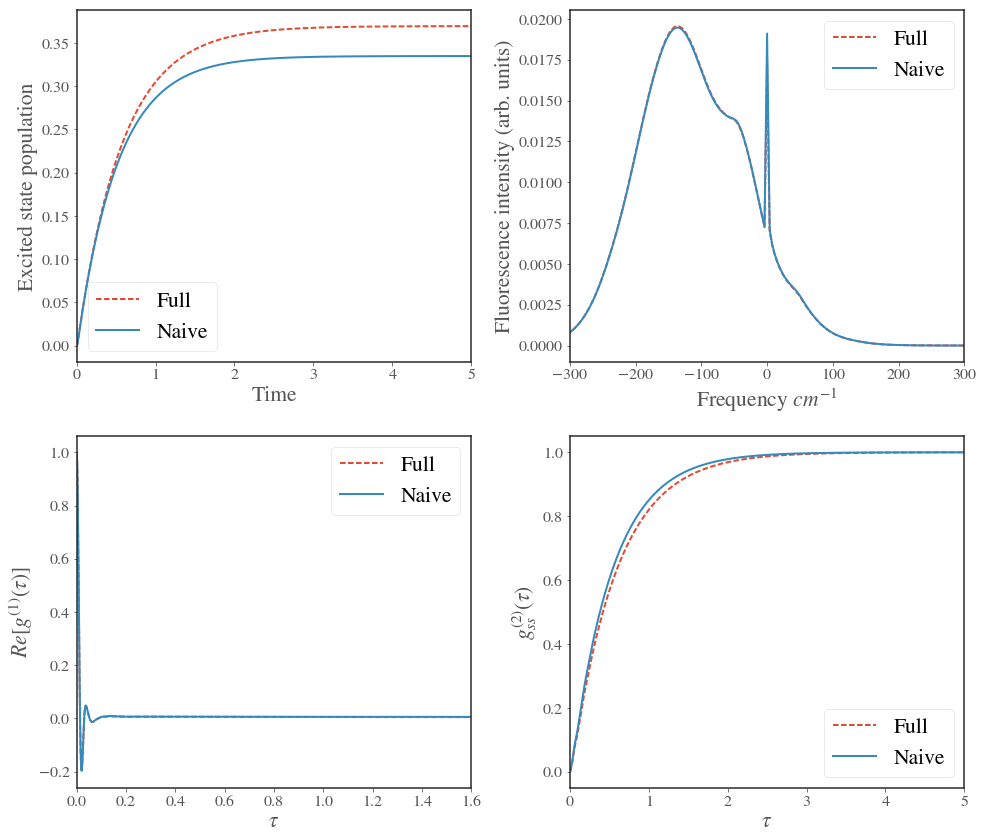

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=62.67 | Gamma_RC=25.00 | alpha_ph=100.00 | N=7 |
It took  0.511677026749  seconds to build the Non-secular RWA Liouvillian
It took  0.21096777916  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.76103196+0.j         -0.02420863+0.02131021j]
 [-0.02420863-0.02131021j  0.23896804+0.j        ]]
Completed initial dynamics calculations for Full in 1.97814893723  seconds.
Completed correlation function calculations for Full in 1.18476009369 seconds.
G2 took 0.995 seconds
Steadystate: 
[[ 0.77622078+0.j         -0.02362708+0.02234414j]
 [-0.02362708-0.02234414j  0.22377922+0.j        ]]
Completed initial dynamics calculations for Naive in 1.9888920784  seconds.
Completed correlation function calculations for Naive in 1.60914683342 seconds.
G2 took 0.722 seconds
All spectra calculated.


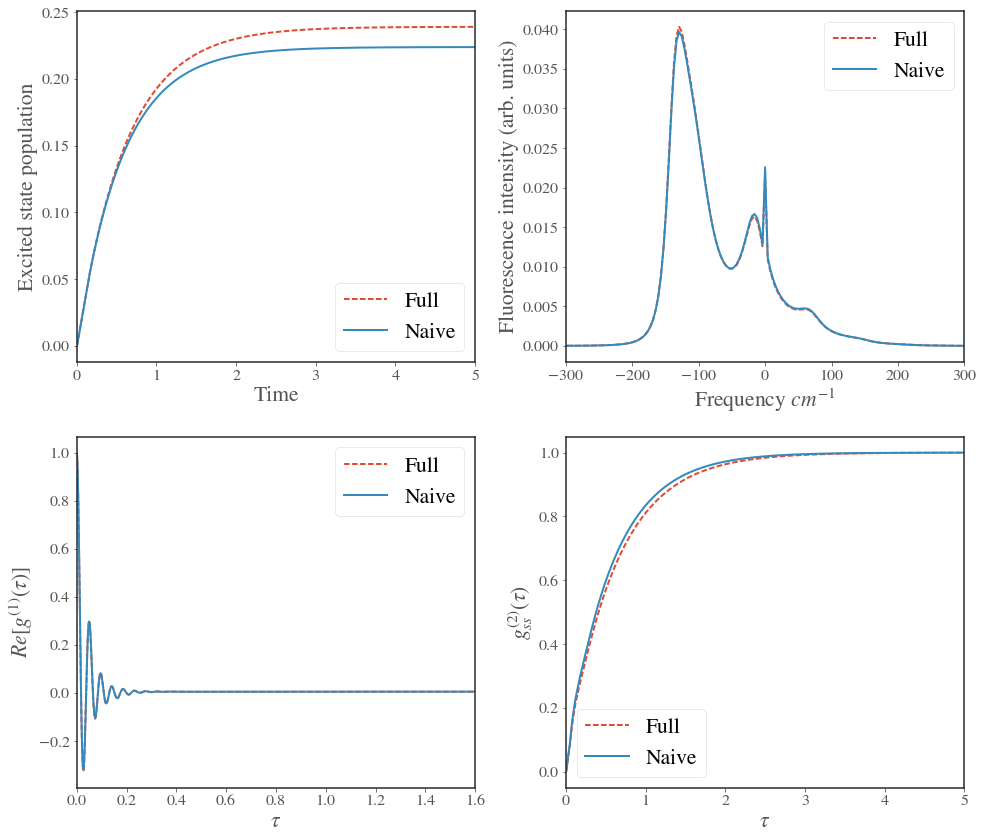

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=44.31 | Gamma_RC=25.00 | alpha_ph=50.00 | N=7 |
It took  0.386615037918  seconds to build the Non-secular RWA Liouvillian
It took  0.208146095276  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.67149798+0.j        -0.02819039+0.0296174j]
 [-0.02819039-0.0296174j  0.32850202+0.j       ]]
Completed initial dynamics calculations for Full in 1.82608699799  seconds.
Completed correlation function calculations for Full in 1.4369161129 seconds.
G2 took 0.777 seconds
Steadystate: 
[[ 0.68888214+0.j         -0.02760870+0.03107291j]
 [-0.02760870-0.03107291j  0.31111786+0.j        ]]
Completed initial dynamics calculations for Naive in 1.9361550808  seconds.
Completed correlation function calculations for Naive in 1.19508218765 seconds.
G2 took 0.820 seconds
All spectra calculated.


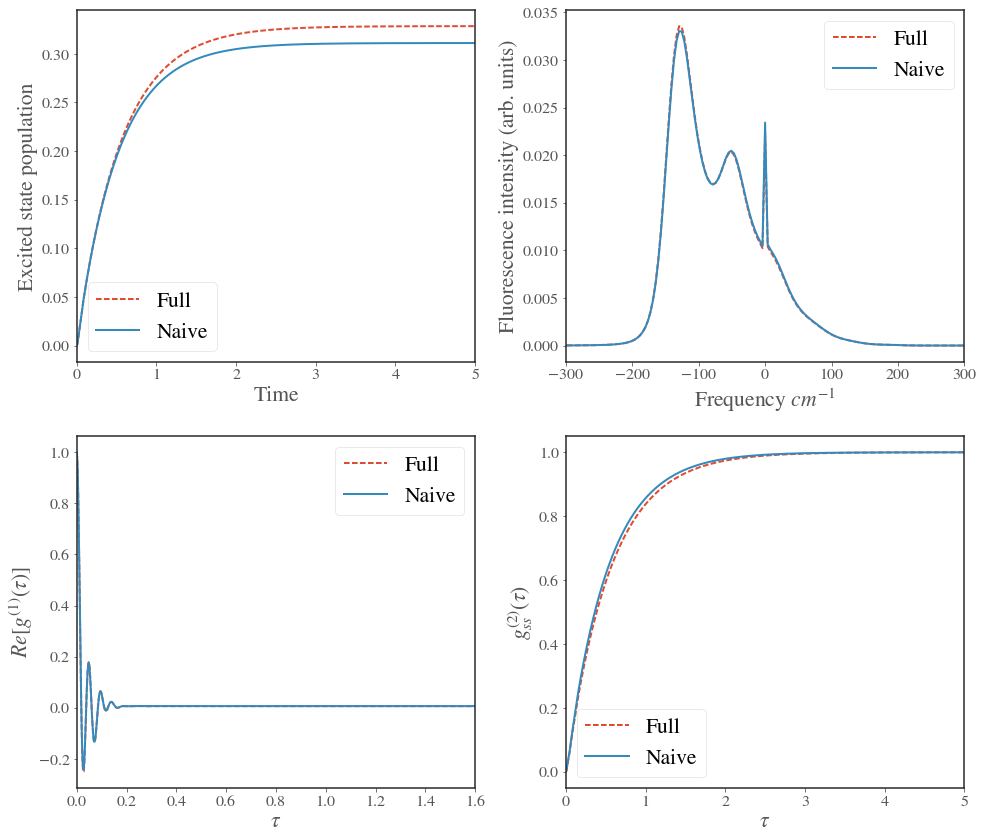

In [29]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=100, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=50, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=100, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=50, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=28.02 | Gamma_RC=25.00 | alpha_ph=10.00 | N=7 |
It took  0.392041921616  seconds to build the Non-secular RWA Liouvillian
It took  0.149307966232  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.59528629+0.j          0.01303181+0.03872117j]
 [ 0.01303181-0.03872117j  0.40471371+0.j        ]]
Completed initial dynamics calculations for Full in 1.3572101593  seconds.
Completed correlation function calculations for Full in 0.952977895737 seconds.
G2 took 0.393 seconds
Steadystate: 
[[ 0.60296238+0.j          0.01433440+0.03973069j]
 [ 0.01433440-0.03973069j  0.39703762+0.j        ]]
Completed initial dynamics calculations for Naive in 1.16486597061  seconds.
Completed correlation function calculations for Naive in 0.922996997833 seconds.
G2 took 0.311 seconds
All spectra calculated.


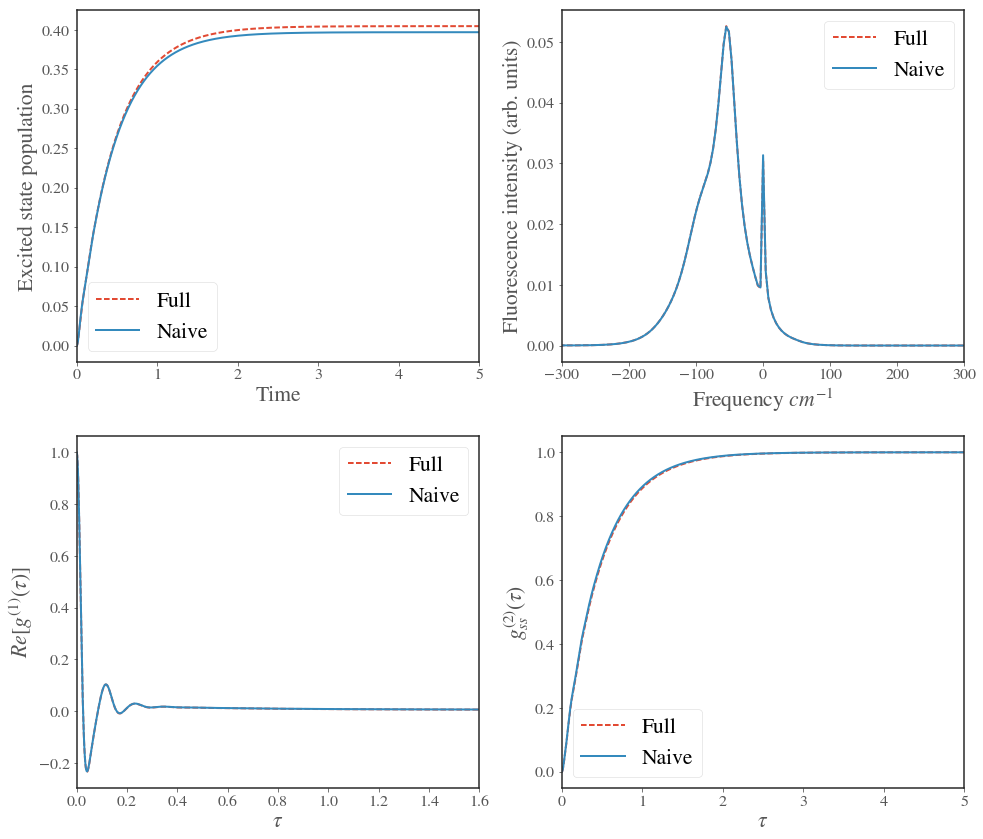

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=50.0 | RC-res. coupling=0.08 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=5.00 | N=7 |
It took  0.355205059052  seconds to build the Non-secular RWA Liouvillian
It took  0.349143981934  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.65930671+0.j          0.03557707+0.03338683j]
 [ 0.03557707-0.03338683j  0.34069329+0.j        ]]
Completed initial dynamics calculations for Full in 1.31622600555  seconds.
Completed correlation function calculations for Full in 1.14694905281 seconds.
G2 took 0.410 seconds
Steadystate: 
[[ 0.66304104+0.j          0.03638318+0.03375614j]
 [ 0.03638318-0.03375614j  0.33695896+0.j        ]]
Completed initial dynamics calculations for Naive in 1.07454609871  seconds.
Completed correlation function calculations for Naive in 0.898280143738 seconds.
G2 took 0.283 seconds
All spectra calculated.


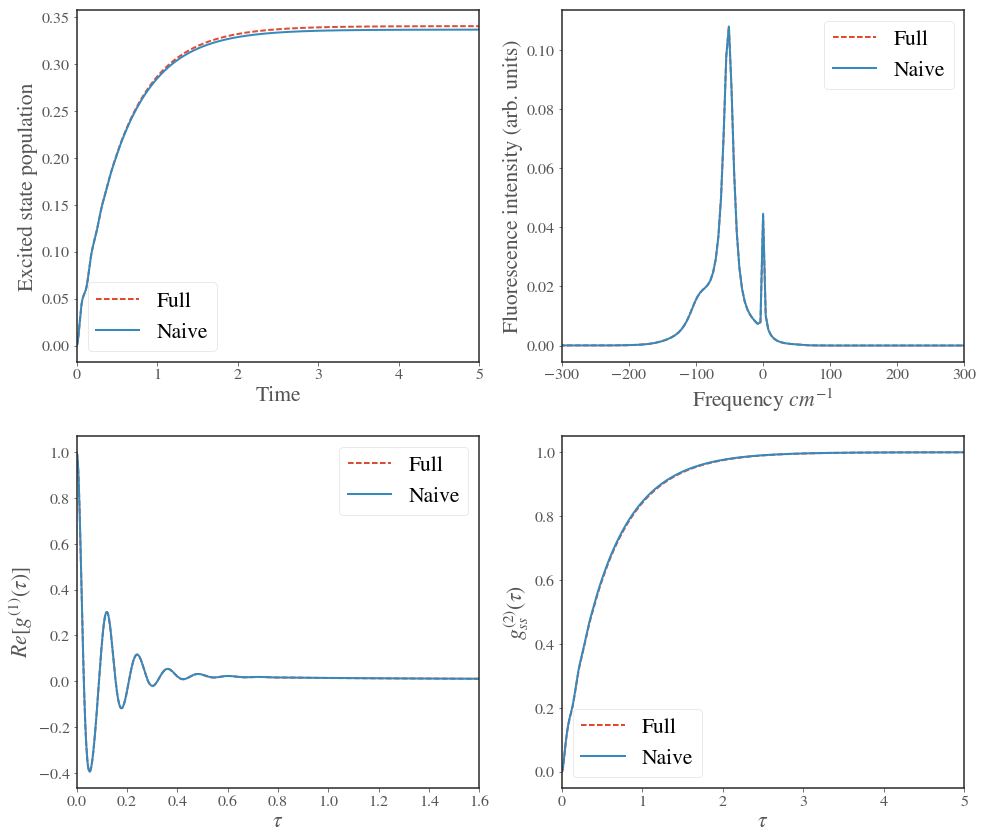

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=19.82 | Gamma_RC=25.00 | alpha_ph=10.00 | N=7 |
It took  0.338986873627  seconds to build the Non-secular RWA Liouvillian
It took  0.152198076248  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.59747071+0.j          0.01525680+0.03932953j]
 [ 0.01525680-0.03932953j  0.40252929+0.j        ]]
Completed initial dynamics calculations for Full in 1.73083615303  seconds.
Completed correlation function calculations for Full in 0.98946595192 seconds.
G2 took 0.951 seconds
Steadystate: 
[[ 0.60250312+0.j          0.01613961+0.03977941j]
 [ 0.01613961-0.03977941j  0.39749688+0.j        ]]
Completed initial dynamics calculations for Naive in 2.04945206642  seconds.
Completed correlation function calculations for Naive in 1.03842902184 seconds.
G2 took 0.819 seconds
All spectra calculated.


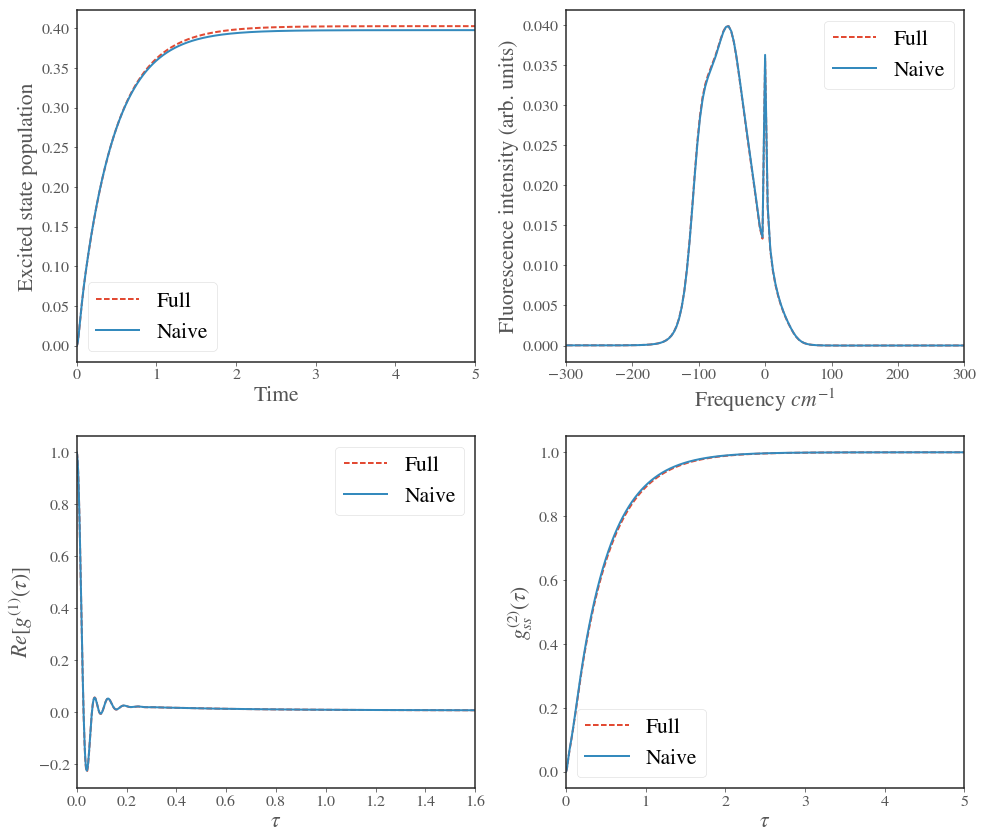

Driven Hamiltonian: 
[[  0.+0.j   5.+0.j]
 [  5.+0.j -50.+0.j]]
w_RC=25.0 | RC-res. coupling=0.16 | TLS-RC coupling=14.01 | Gamma_RC=25.00 | alpha_ph=5.00 | N=7 |
It took  0.341111183167  seconds to build the Non-secular RWA Liouvillian
It took  0.146584033966  seconds to build the Non-secular RWA Liouvillian
Steadystate: 
[[ 0.68116812+0.j          0.05188392+0.03175018j]
 [ 0.05188392-0.03175018j  0.31883188+0.j        ]]
Completed initial dynamics calculations for Full in 1.36547613144  seconds.
Completed correlation function calculations for Full in 0.97603392601 seconds.
G2 took 0.589 seconds
Steadystate: 
[[ 0.68302059+0.j          0.05229715+0.03178252j]
 [ 0.05229715-0.03178252j  0.31697941+0.j        ]]
Completed initial dynamics calculations for Naive in 1.55240893364  seconds.
Completed correlation function calculations for Naive in 1.0134370327 seconds.
G2 took 0.589 seconds
All spectra calculated.


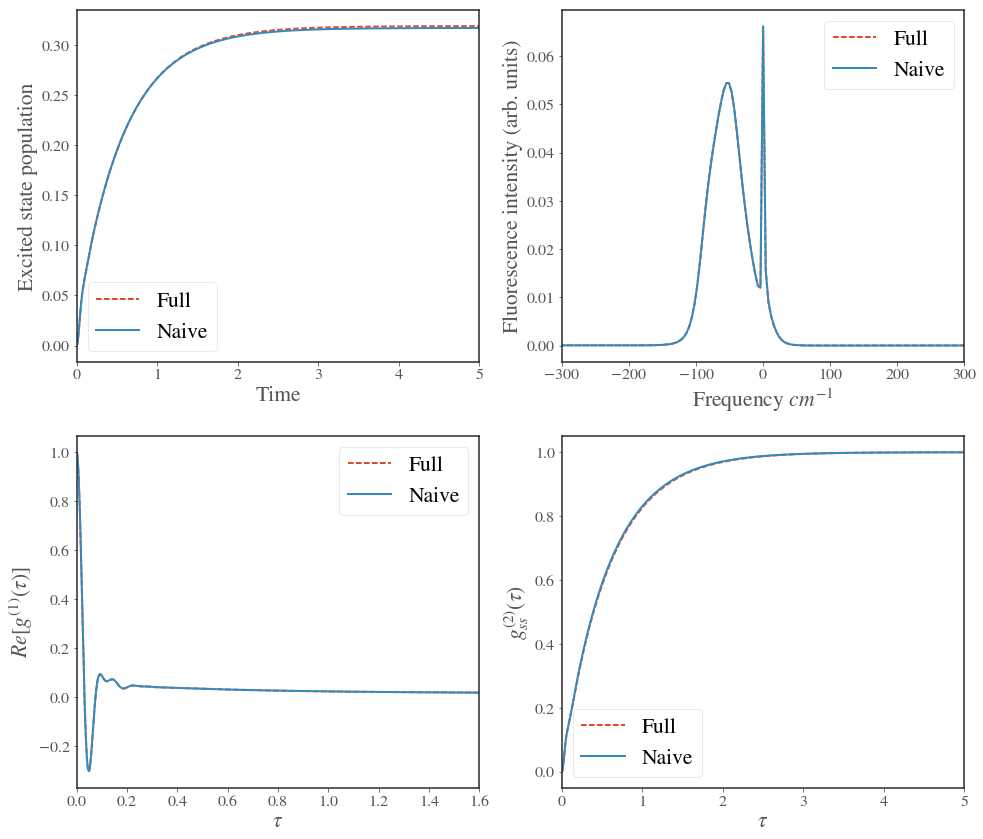

In [30]:
timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=5, Rabi=10., w0=50.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=10, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)

timelist, pop_list, taulist, g1, spectrum, freq, g2 = RF_data(detuning=50, alpha=5, Rabi=10., w0=25.,
                                                                             t_f=5, steps_per_tau=500, nsteps=3000, 
                                                                             tau_f=1.6)
plot_spectra(timelist, pop_list, taulist, g1, spectrum, freq, g2,
                freq_window=300., tau_window=1., dyn_window_div=1.)